# Sentiment Analysis: Twitter vs Amazon Review Data

This notebook compares different sentiment analysis models on Twitter and Amazon datasets.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from copy import deepcopy
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Input, Attention, GlobalAveragePooling1D
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# from google.colab import drive
# drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Loading

In [3]:
amazon_data = pd.read_csv('amazon_reviews.csv')
amazon_data.head(10)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.000000
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.000000
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.000000
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.000000
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.000000
5,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.000000
6,6,2K1Toaster,5.0,I have it in my phone and it never skips a bea...,2013-10-19,415,0,0,0,0,0.0,0.000000
7,7,"35-year Technology Consumer ""8-tracks to 802.11""",5.0,It's hard to believe how affordable digital ha...,2014-10-07,62,0,0,0,0,0.0,0.000000
8,8,4evryoung,5.0,Works in a HTC Rezound. Was running short of ...,2014-03-24,259,1,0,1,1,1.0,0.206549
9,9,53rdcard,5.0,"in my galaxy s4, super fast card, and am total...",2013-11-10,393,0,0,0,0,0.0,0.000000


In [4]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [5]:
amazon_data.duplicated().sum()

np.int64(0)

In [6]:
amazon_data.isnull().sum()

,0
Unnamed: 0,0
reviewerName,1
overall,0
reviewText,1
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [7]:
amazon_data.dropna(subset=['reviewerName', 'reviewText'], inplace=True)

amazon_data.drop_duplicates(subset=['reviewText'], keep='first', inplace=True)
amazon_data.reset_index(drop=True, inplace=True)

display(amazon_data.head())
print(amazon_data.shape)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


(4912, 12)


In [8]:
def categorize_sentiment(row):
    if row['overall'] > 3:
        return 'positive'
    elif row['overall'] < 3:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the 'type' column
amazon_data['type'] = amazon_data.apply(categorize_sentiment, axis=1)

# Display the first few rows to verify the new column
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [9]:
df = deepcopy(amazon_data)
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [10]:
df['type'].value_counts()

,count
type,
positive,4446
negative,324
neutral,142


In [11]:
df.isnull().sum()

,0
Unnamed: 0,0
reviewerName,0
overall,0
reviewText,0
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


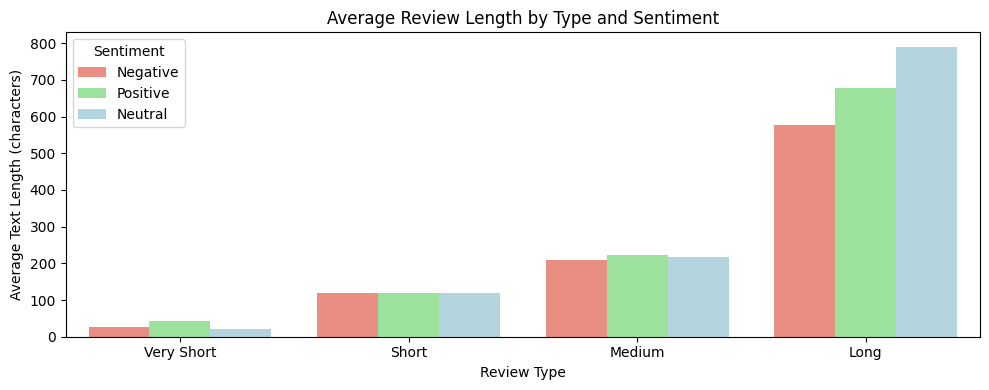

In [12]:
# Calculate text length for each review
df['text_length'] = df['reviewText'].apply(len)

# Define bins and labels for review length
bins = [0, 50, 150, 300, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long']
df['review_type'] = pd.cut(df['text_length'], bins=bins, labels=labels)

# Ensure sentiment column exists
if 'sentiment' not in df.columns:
    df['sentiment'] = (df['overall'] > 3).astype(int)

# Create a grouped bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='review_type', y='text_length', hue='type',
           data=df, palette=['salmon', 'lightgreen', 'lightblue'],
           ci=None)  # No confidence intervals

plt.title('Average Review Length by Type and Sentiment')
plt.xlabel('Review Type')
plt.ylabel('Average Text Length (characters)')
plt.legend(title='Sentiment', labels=['Negative', 'Positive', 'Neutral'])
plt.tight_layout()
plt.show()

In [13]:
# Fill NaNs with empty string
df['reviewText'] = df['reviewText'].fillna('')

df['lower'] = df['reviewText'].str.lower()
df['lower'] = df['lower'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['lower'] = df['lower'].apply(lambda x: re.sub(r'\d+', '', x))
df['lower'] = [str(i).strip() for i in df['lower']]

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

df['lower'] = df['lower'].apply(preprocess_text)
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type,text_length,review_type,sentiment,lower
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive,158,Medium,1,"[purchas, devic, work, advertis, never, much, ..."
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive,166,Medium,1,"[work, expect, sprung, higher, capac, think, m..."
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive,340,Long,1,"[think, work, greathad, diff, bran, gb, card, ..."
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive,290,Medium,1,"[bought, retail, packag, arriv, legit, orang, ..."
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive,282,Medium,1,"[mini, storag, doesnt, anyth, el, suppos, purc..."


In [14]:
# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
# Use the multi-class 'type' column instead of 'sentiment'
y = df['type']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=42,
                                                    shuffle=True)

# Initialize and train the Logistic Regression model on the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Define a function to train and evaluate the model
y_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred, average='macro')
lr_recall = recall_score(y_test, y_pred, average='macro')
lr_f1 = f1_score(y_test, y_pred, average='macro')
lr_auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred))

print("Logistic Regression Evaluation Metrics:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print(f"AUC-ROC: {lr_auc_roc:.4f}")

Logistic Regression Evaluation Metrics:
Accuracy: 0.9268
Precision: 0.5577
Recall: 0.5076
F1 Score: 0.5277
AUC-ROC: 0.6570


In [15]:
# print Classification Report
print("Classification Report for Logistic Regression")
print(classification_report(y_test, y_pred))

Classification Report for Logistic Regression
              precision    recall  f1-score   support

    negative       0.73      0.54      0.62        65
     neutral       0.00      0.00      0.00        28
    positive       0.94      0.98      0.96       890

    accuracy                           0.93       983
   macro avg       0.56      0.51      0.53       983
weighted avg       0.90      0.93      0.91       983



<Figure size 800x600 with 0 Axes>

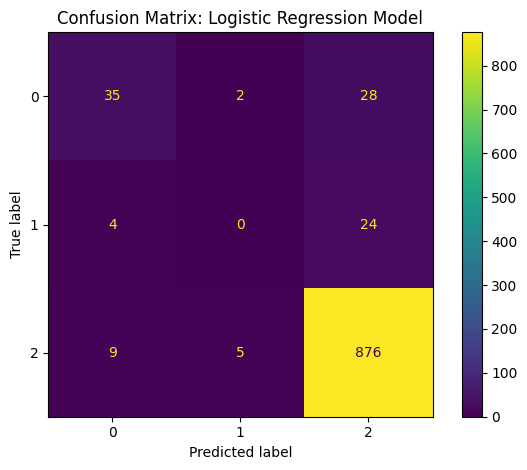

In [16]:
# Confusion Matrix of Logistic Regression
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model')
plt.grid(False)
plt.tight_layout()

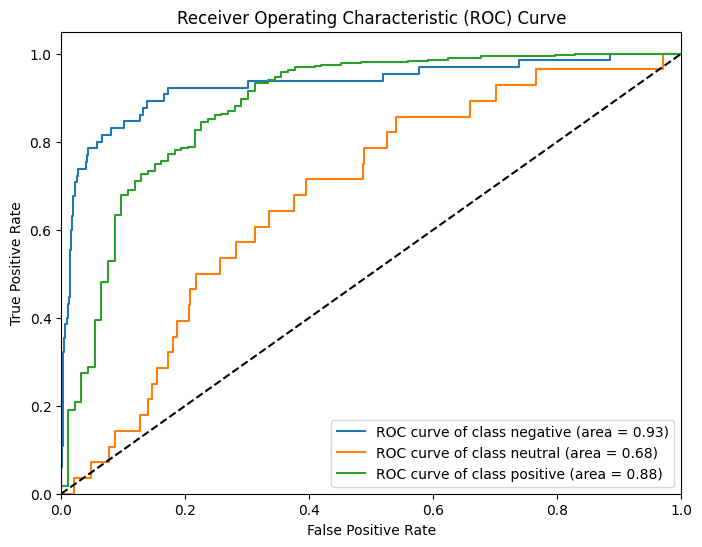

In [17]:
# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
y_pred_prob = lr.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {["negative", "neutral", "positive"][i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [18]:
# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize and train the Logistic Regression model on the resampled data
lr_smote = LogisticRegression(max_iter=1000)
lr_smote_accuracy = accuracy_score(y_test, y_pred)
lr_smote_precision = precision_score(y_test, y_pred, average='macro')
lr_smote_recall = recall_score(y_test, y_pred, average='macro')
lr_smote_f1 = f1_score(y_test, y_pred, average='macro')
lr_smote_auc_roc = roc_auc_score(pd.get_dummies(y_test),
                                 pd.get_dummies(y_pred))

lr_smote.fit(X_train_smote, y_train_smote)

print("Logistic Regression Model after SMOTE Evaluation Metrics:")
print(f"Accuracy: {lr_smote_accuracy:.4f}")
print(f"Precision: {lr_smote_precision:.4f}")
print(f"Recall: {lr_smote_recall:.4f}")
print(f"F1 Score: {lr_smote_f1:.4f}")
print(f"AUC-ROC: {lr_smote_auc_roc:.4f}")

Logistic Regression Model after SMOTE Evaluation Metrics:
Accuracy: 0.9268
Precision: 0.5577
Recall: 0.5076
F1 Score: 0.5277
AUC-ROC: 0.6570


In [19]:
lr_smote_y_pred = lr_smote.predict(X_test)

# Print the classification report
print("Classification Report: Logistic Regression with SMOTE")
print(classification_report(y_test, lr_smote_y_pred))

Classification Report: Logistic Regression with SMOTE
              precision    recall  f1-score   support

    negative       0.47      0.58      0.52        65
     neutral       0.02      0.04      0.03        28
    positive       0.95      0.91      0.93       890

    accuracy                           0.86       983
   macro avg       0.48      0.51      0.49       983
weighted avg       0.89      0.86      0.88       983



<Figure size 800x600 with 0 Axes>

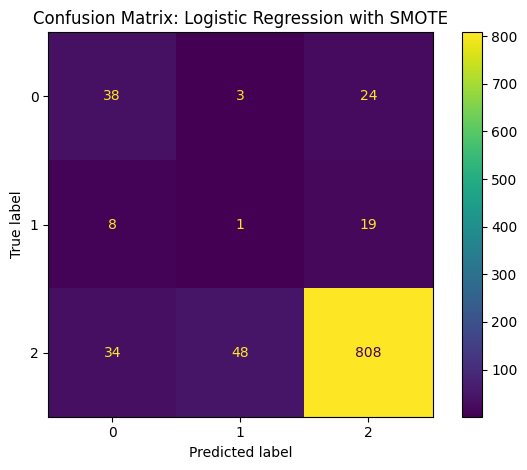

In [20]:
# Plot the confusion matrix
cm_smote = confusion_matrix(y_test, lr_smote_y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression with SMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

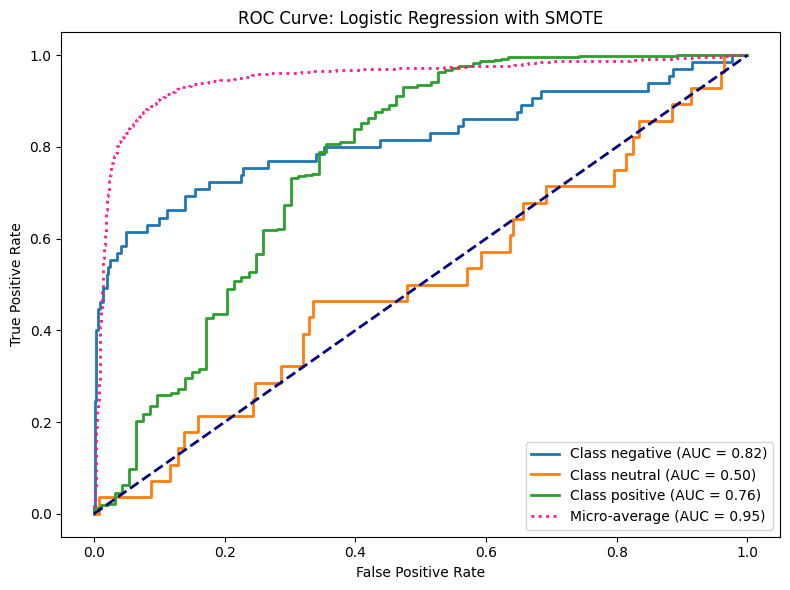

In [21]:
# Plot ROC Curve for multi-class classification
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr_smote.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), lr_smote.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression with SMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [22]:
# Train Oversampling using SMOTENC
# Perform Logistic Regression with SMOTENC

# Identify categorical features in df
categorical_features = [i for i, col in enumerate(df.columns) if df[col].dtype == 'object']

# Initialize SMOTENC with the categorical feature indices
smotenc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_smotenc_train, y_smotenc_train = smotenc.fit_resample(X, y)

lr_smotenc = LogisticRegression(max_iter=1000)
lr_smotenc.fit(X_smotenc_train, y_smotenc_train)
y_pred_smotenc = lr_smotenc.predict(X_test)

lr_accuracy_smotenc = accuracy_score(y_test, y_pred_smotenc)
lr_precision_smotenc = precision_score(y_test, y_pred_smotenc, average='macro')
lr_recall_smotenc = recall_score(y_test, y_pred_smotenc, average='macro')
lr_f1_smotenc = f1_score(y_test, y_pred_smotenc, average='macro')
lr_auc_roc_smotenc = roc_auc_score(pd.get_dummies(y_test),
                                   pd.get_dummies(y_pred_smotenc))

print("Logistic Regression Model after SMOTENC Evaluation Metrics on Train Set:")
print(f"Accuracy: {lr_accuracy_smotenc:.4f}")
print(f"Precision: {lr_precision_smotenc:.4f}")
print(f"Recall: {lr_recall_smotenc:.4f}")
print(f"F1 Score: {lr_f1_smotenc:.4f}")
print(f"AUC-ROC: {lr_auc_roc_smotenc:.4f}")

Logistic Regression Model after SMOTENC Evaluation Metrics on Train Set:
Accuracy: 0.9715
Precision: 0.8250
Recall: 0.8925
F1 Score: 0.8552
AUC-ROC: 0.9300


<Figure size 800x600 with 0 Axes>

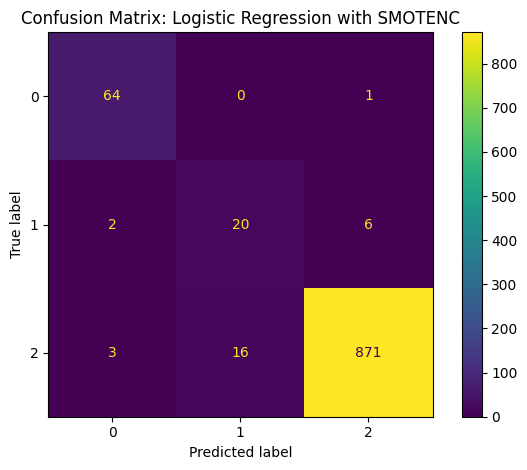

In [23]:
cm_smotenc = confusion_matrix(y_test, y_pred_smotenc)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smotenc)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression with SMOTENC')
plt.grid(False)
plt.tight_layout()
plt.show()


In [24]:
# Classification Report for Logistic Regression Model after SMOTENC
print("Classification Report for Logistic Regression after SMOTENC")
print(classification_report(y_test, y_pred_smotenc))

Classification Report for Logistic Regression after SMOTENC
              precision    recall  f1-score   support

    negative       0.93      0.98      0.96        65
     neutral       0.56      0.71      0.62        28
    positive       0.99      0.98      0.99       890

    accuracy                           0.97       983
   macro avg       0.83      0.89      0.86       983
weighted avg       0.98      0.97      0.97       983



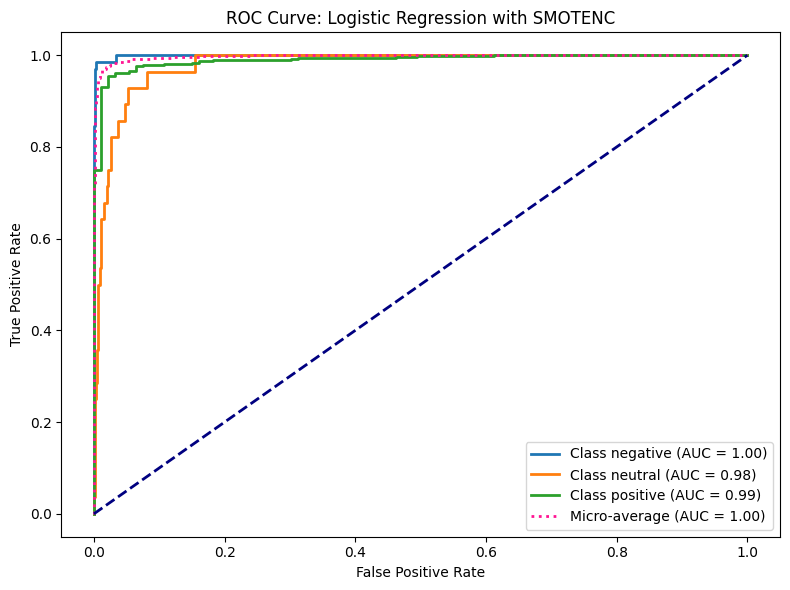

In [25]:
# Plot ROC Curve for multi-class classification after SMOTENC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr_smotenc.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), lr_smotenc.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression with SMOTENC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [26]:
from collections import Counter
print("Applying ADASYN to the original dataset...")
adasyn = ADASYN(random_state=42)
# Use original X, y before any resampling
# Ensure X and y reflect the state after preprocessing in Cell 13
# but before SMOTE in Cell 14
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df['type']
print("Splitting original data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True)

print("Train/test split complete.")
print("Training set distribution before ADASYN:", Counter(y_train))
print("Test set distribution:", Counter(y_test))

print("Applying ADASYN to the training set...")
X_train, y_train = adasyn.fit_resample(X_train, y_train)
print("ADASYN complete on training set.")

# Initialize and train Logistic Regression model
print("Training Logistic Regression model on ADASYN data...")
lr = LogisticRegression(max_iter=1000)

#Fit the model before predicting
lr.fit(X_train, y_train)

y_pred_adasyn = lr.predict(X_test)

# Use the train_evaluate_model function defined in Cell 14
lr_accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)
lr_precision_adasyn = precision_score(y_test, y_pred_adasyn, average='macro')
lr_recall_adasyn = recall_score(y_test, y_pred_adasyn, average='macro')
lr_f1_adasyn = f1_score(y_test, y_pred_adasyn, average='macro')
lr_auc_roc_adasyn = roc_auc_score(pd.get_dummies(y_test),
                                  pd.get_dummies(y_pred_adasyn))

print('Logistic Regression after ADASYN Evaluation Metrics')
print(f"Accuracy: {lr_accuracy_adasyn:.4f}")
print(f"Precision: {lr_precision_adasyn:.4f}")
print(f"Recall: {lr_recall_adasyn:.4f}")
print(f"F1 Score: {lr_f1_adasyn:.4f}")
print(f"AUC-ROC: {lr_auc_roc_adasyn:.4f}")

Applying ADASYN to the original dataset...
Splitting original data into train/test sets...
Train/test split complete.
Training set distribution before ADASYN: Counter({'positive': 3556, 'negative': 259, 'neutral': 114})
Test set distribution: Counter({'positive': 890, 'negative': 65, 'neutral': 28})
Applying ADASYN to the training set...
ADASYN complete on training set.
Training Logistic Regression model on ADASYN data...
Logistic Regression after ADASYN Evaluation Metrics
Accuracy: 0.8657
Precision: 0.4856
Recall: 0.5109
F1 Score: 0.4959
AUC-ROC: 0.6626


In [27]:
# Classification Report after ADASYN
print('------------------------------------------------------------')
print('Logistic Regression Model after ADASYN Classification Report')
print('------------------------------------------------------------')
# y_pred_adasyn is returned by train_evaluate_model
print(classification_report(y_test, y_pred_adasyn))

------------------------------------------------------------
Logistic Regression Model after ADASYN Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.49      0.58      0.53        65
     neutral       0.02      0.04      0.03        28
    positive       0.95      0.91      0.93       890

    accuracy                           0.87       983
   macro avg       0.49      0.51      0.50       983
weighted avg       0.89      0.87      0.88       983



-----------------------------------------------------
Confusion Matrix of Logistic Regression after ADASYN
-----------------------------------------------------


<Figure size 800x600 with 0 Axes>

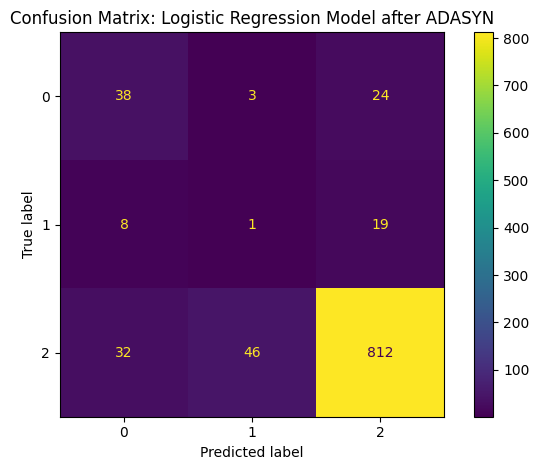

In [28]:
# Compute and display the confusion matrix
print('-----------------------------------------------------')
print('Confusion Matrix of Logistic Regression after ADASYN')
print('-----------------------------------------------------')
cm_multi_adasyn = confusion_matrix(y_test, y_pred_adasyn)
plt.figure(figsize=(8, 6))
# Get class labels dynamically and sort them for consistent display
labels_order = sorted(y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_adasyn)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after ADASYN')
plt.grid(False)
plt.tight_layout()
plt.show()

-------------------------------------------------
ROC Curve: Logistic Regression Model after ADASYN
-------------------------------------------------


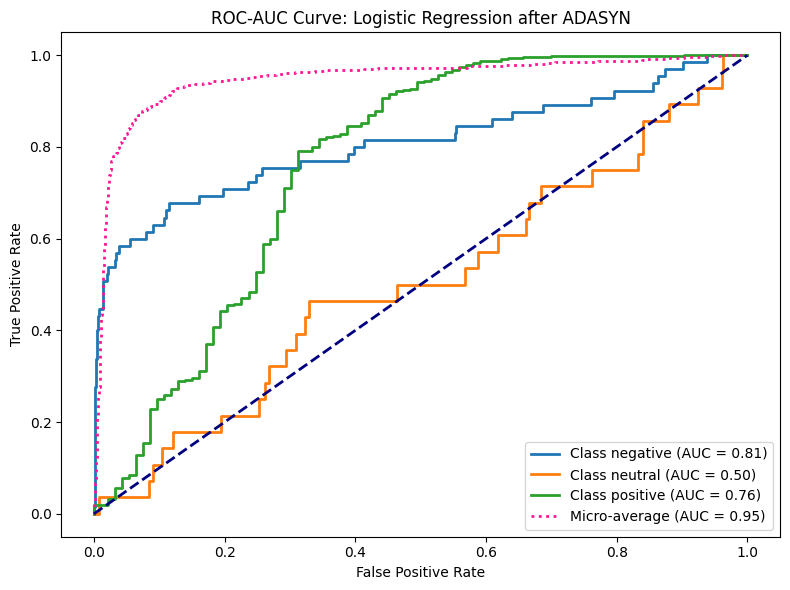

In [29]:
# Plot ROC Curve
print('-------------------------------------------------')
print('ROC Curve: Logistic Regression Model after ADASYN')
print('-------------------------------------------------')
plt.figure(figsize=(8, 6))

# Binarize the output labels for multi-class ROC curve
classes_ = sorted(y_test.unique()) # Use sorted unique classes from y_test
y_test_binarized = label_binarize(y_test, classes=classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(classes_):
    # Use predict_proba from the trained model 'lr'
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), lr.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: Logistic Regression after ADASYN')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [30]:
from collections import Counter

# performing BorderlineSMOTE on logistic Regression
print("Applying BorderlineSMOTE to the training dataset...")

# Ensure X and y are the original data before any resampling
# Re-run CountVectorizer if necessary, or use X, y from Cell 14
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df['type']

# Split the original data into training and testing sets first
print("Splitting original data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True)

print("Train/test split complete.")
print("Training set distribution before BorderlineSMOTE:",
      Counter(y_train))
print("Test set distribution:", Counter(y_test))

# Apply BorderlineSMOTE only to the training set
print("Applying BorderlineSMOTE to the training set...")
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_bsmote, y_train_bsmote = borderline_smote.fit_resample(X_train,
                                                               y_train)
print("BorderlineSMOTE complete on training set.")
print("Training set distribution after BorderlineSMOTE:",
      Counter(y_train_bsmote))


# Initialize and train Logistic Regression model on the
# BorderlineSMOTE-resampled training data
print("Training Logistic Regression model on BorderlineSMOTE data...")
lr = LogisticRegression(max_iter=1000)

# Fit the model to the training data
lr.fit(X_train_bsmote, y_train_bsmote)

y_pred_borderline_smote = lr.predict(X_test)
lr_accuracy_borderline_smote = accuracy_score(y_test, y_pred_borderline_smote)
lr_precision_borderline_smote = precision_score(y_test,
                                                y_pred_borderline_smote,
                                                average='macro')
lr_recall_borderline_smote = recall_score(y_test,
                                          y_pred_borderline_smote,
                                          average='macro')
lr_f1_borderline_smote = f1_score(y_test, y_pred_borderline_smote,
                                  average='macro')
lr_auc_roc_borderline_smote = roc_auc_score(pd.get_dummies(y_test),
                                            pd.get_dummies(y_pred_borderline_smote))

print('Logistic Regression after BorderlineSMOTE Evaluation Metrics')
print(f"Accuracy: {lr_accuracy_borderline_smote:.4f}")
print(f"Precision: {lr_precision_borderline_smote:.4f}")
print(f"Recall: {lr_recall_borderline_smote:.4f}")
print(f"F1 Score: {lr_f1_borderline_smote:.4f}")
print(f"AUC-ROC: {lr_auc_roc_borderline_smote:.4f}")

Applying BorderlineSMOTE to the training dataset...
Splitting original data into train/test sets...
Train/test split complete.
Training set distribution before BorderlineSMOTE: Counter({'positive': 3556, 'negative': 259, 'neutral': 114})
Test set distribution: Counter({'positive': 890, 'negative': 65, 'neutral': 28})
Applying BorderlineSMOTE to the training set...
BorderlineSMOTE complete on training set.
Training set distribution after BorderlineSMOTE: Counter({'positive': 3556, 'negative': 3556, 'neutral': 3556})
Training Logistic Regression model on BorderlineSMOTE data...
Logistic Regression after BorderlineSMOTE Evaluation Metrics
Accuracy: 0.8749
Precision: 0.4941
Recall: 0.5163
F1 Score: 0.5035
AUC-ROC: 0.6652


In [31]:
# Classification Report after BorderlineSMOTE
print('---------------------------------------------------------------------')
print('Logistic Regression Model after BorderlineSMOTE Classification Report')
print('---------------------------------------------------------------------')
print(classification_report(y_test, y_pred_borderline_smote))

---------------------------------------------------------------------
Logistic Regression Model after BorderlineSMOTE Classification Report
---------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.49      0.55      0.52        65
     neutral       0.05      0.07      0.06        28
    positive       0.95      0.92      0.94       890

    accuracy                           0.87       983
   macro avg       0.49      0.52      0.50       983
weighted avg       0.89      0.87      0.88       983



--------------------------------------------------------------
Confusion Matrix of Logistic Regression after BorderlineSMOTE
--------------------------------------------------------------


<Figure size 800x600 with 0 Axes>

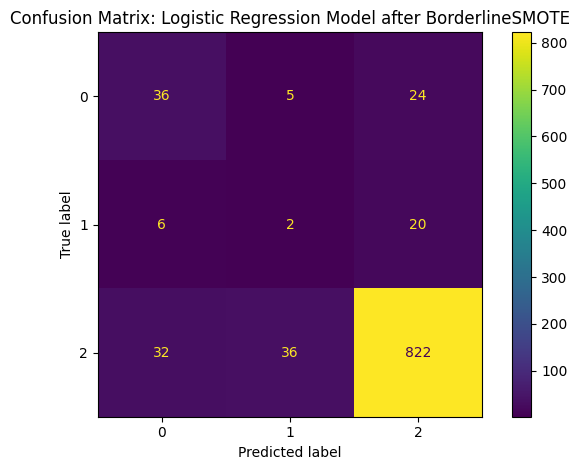

In [32]:
# Compute and display the confusion matrix
print('--------------------------------------------------------------')
print('Confusion Matrix of Logistic Regression after BorderlineSMOTE')
print('--------------------------------------------------------------')
cm_multi_borderline_smote = confusion_matrix(y_test, y_pred_borderline_smote)
plt.figure(figsize=(8, 6))
# Get class labels dynamically and sort them for consistent display
labels_order = sorted(y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi_borderline_smote)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after BorderlineSMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

----------------------------------------------------------
ROC Curve: Logistic Regression Model after BorderlineSMOTE
----------------------------------------------------------


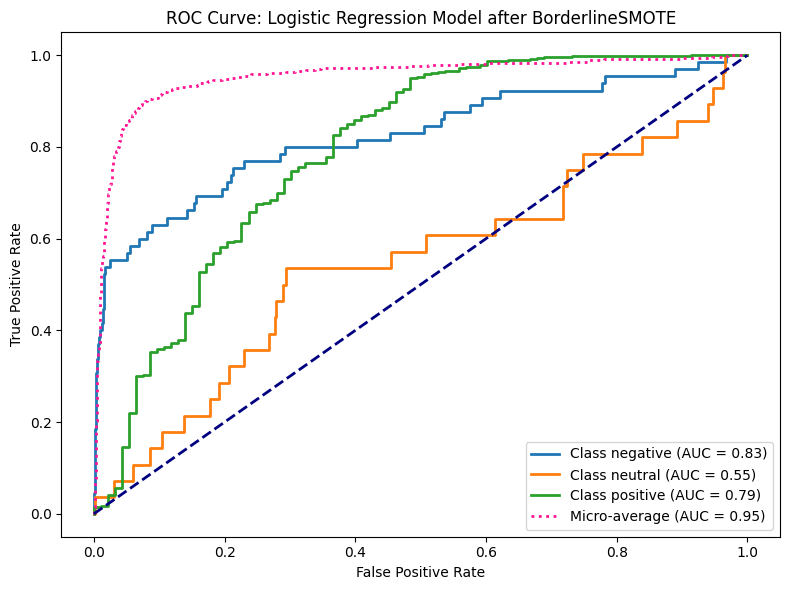

In [33]:
# Plot ROC Curve
print('----------------------------------------------------------')
print('ROC Curve: Logistic Regression Model after BorderlineSMOTE')
print('----------------------------------------------------------')
plt.figure(figsize=(8, 6))
# Binarize the output labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=labels_order)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
for i, class_label in enumerate(labels_order):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), lr.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve: Logistic Regression Model after BorderlineSMOTE')
plt.tight_layout()
plt.show()

In [34]:
# Define features and target variable
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True)

# Perform SVMSMOTE on the training set
svm_smote = SVMSMOTE(random_state=42)
X_train, y_train = svm_smote.fit_resample(X_train, y_train)

# Fit a Logistic Regression model on the resampled training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_svm_smote = lr.predict(X_test)
# Evaluate the model on the (unchanged) test set
lr_svm_accuracy = accuracy_score(y_test, lr.predict(X_test))
lr_svm_precision = precision_score(y_test, y_pred_svm_smote, average='macro')
lr_svm_recall = recall_score(y_test, y_pred_svm_smote, average='macro')
lr_svm_f1 = f1_score(y_test, y_pred_svm_smote, average='macro')
lr_svm_auc_roc = roc_auc_score(pd.get_dummies(y_test),
                               pd.get_dummies(y_pred_svm_smote))

In [35]:
print("Classification Report for Logistic Regression Model after SVMSMOTE")
y_pred_svm_smote = lr.predict(X_test)
print(classification_report(y_test, y_pred_svm_smote))

Classification Report for Logistic Regression Model after SVMSMOTE
              precision    recall  f1-score   support

    negative       0.55      0.57      0.56        65
     neutral       0.05      0.07      0.06        28
    positive       0.95      0.93      0.94       890

    accuracy                           0.89       983
   macro avg       0.52      0.52      0.52       983
weighted avg       0.90      0.89      0.89       983



<Figure size 800x600 with 0 Axes>

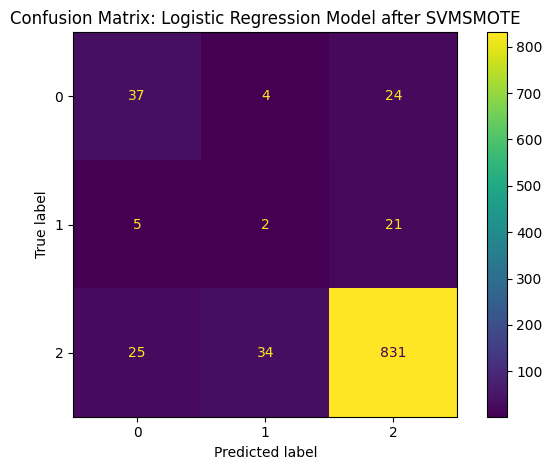

In [36]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model after SVMSMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

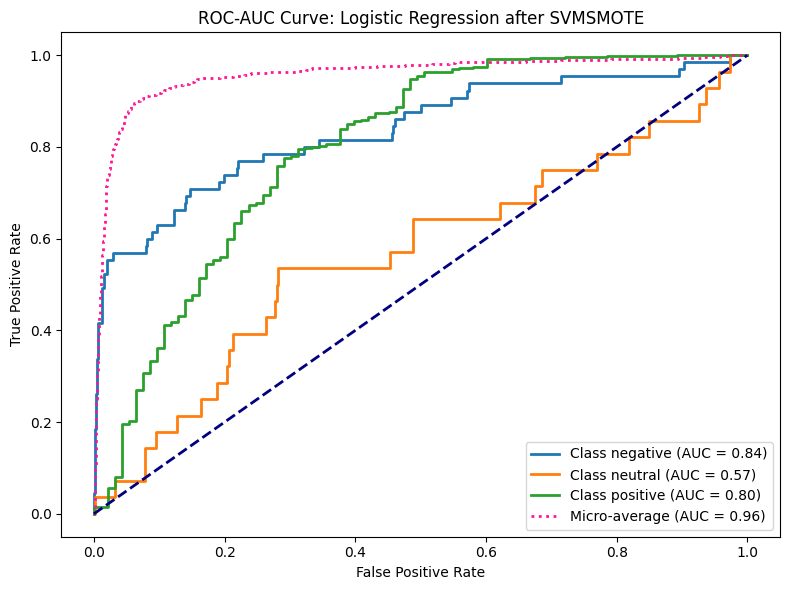

In [37]:
# Binarize the output labels for the multi-class ROC curve
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Plot micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), lr.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: Logistic Regression after SVMSMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

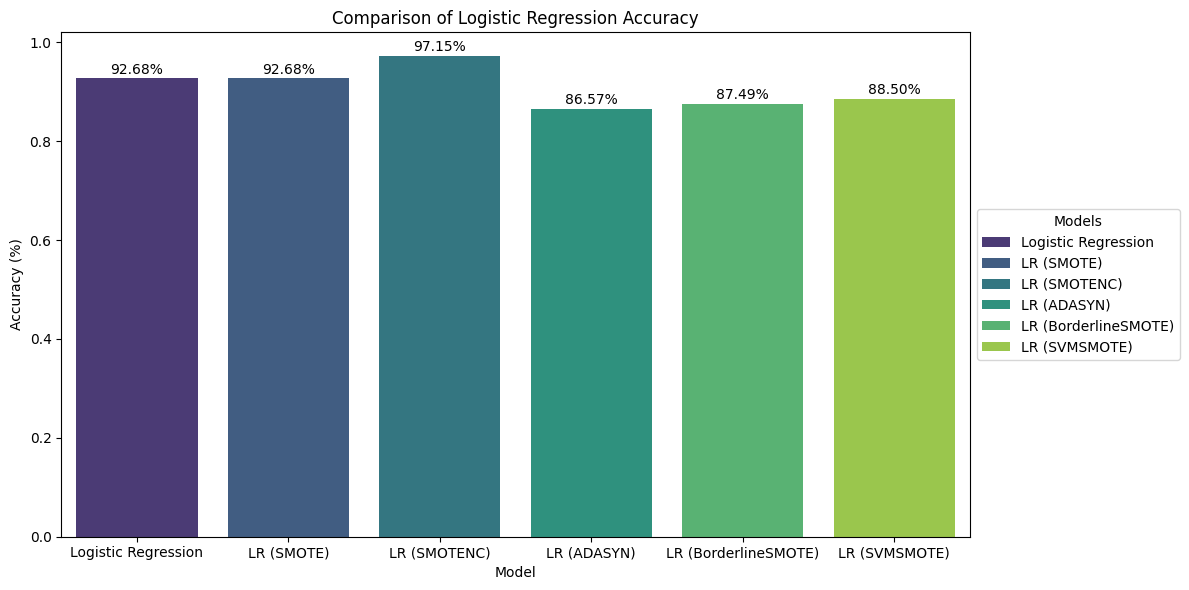

In [38]:
models = ['Logistic Regression', 'LR (SMOTE)', 'LR (SMOTENC)',
          'LR (ADASYN)', 'LR (BorderlineSMOTE)', 'LR (SVMSMOTE)']
accuracy_scores = [lr_accuracy, lr_accuracy, lr_accuracy_smotenc, lr_accuracy_adasyn,
                   lr_accuracy_borderline_smote, lr_svm_accuracy]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=models, y=accuracy_scores, palette="viridis")
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Logistic Regression Accuracy')
plt.xticks(fontsize=10)

for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center')

handles = ax.patches
labels = models

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models',
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [39]:
# Prepare features and target using CountVectorizer on preprocessed text
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Initialize the Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)
# Train and evaluate the model using the pre-defined
# train_evaluate_model function
nb_y_pred = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred,
                               average='macro')
nb_recall = recall_score(y_test, nb_y_pred,
                         average='macro')
nb_f1 = f1_score(y_test, nb_y_pred, average='macro')
nb_roc_auc = roc_auc_score(pd.get_dummies(y_test),
                           pd.get_dummies(nb_y_pred))

print("Multinomial Naive Bayes Model Evaluation Metrics:")
print(f'Accuracy: {nb_accuracy:.4f}')
print(f'Precision: {nb_precision:.4f}')
print(f'Recall: {nb_recall:.4f}')
print(f'F1 Score: {nb_f1:.4f}')
print(f'ROC-AUC: {nb_roc_auc:.4f}')

Multinomial Naive Bayes Model Evaluation Metrics:
Accuracy: 0.9298
Precision: 0.5389
Recall: 0.5325
F1 Score: 0.5352
ROC-AUC: 0.6796


In [40]:
# Generate and print the classification report for the Multinomial Naive Bayes model
y_pred = nb.predict(X_test)
print("Classification Report for Multinomial Naive Bayes Model")
print(classification_report(y_test, nb_y_pred))

Classification Report for Multinomial Naive Bayes Model
              precision    recall  f1-score   support

    negative       0.67      0.62      0.64        65
     neutral       0.00      0.00      0.00        28
    positive       0.95      0.98      0.97       890

    accuracy                           0.93       983
   macro avg       0.54      0.53      0.54       983
weighted avg       0.90      0.93      0.92       983



<Figure size 800x600 with 0 Axes>

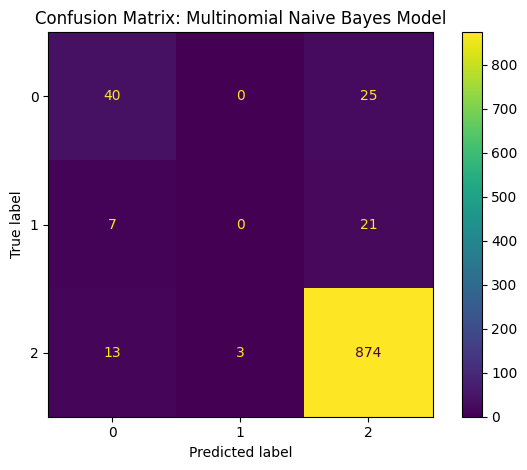

In [41]:
# Predict using the Multinomial Naive Bayes model
y_pred = nb.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, nb_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Multinomial Naive Bayes Model')
plt.tight_layout()
plt.grid(False)
plt.show()

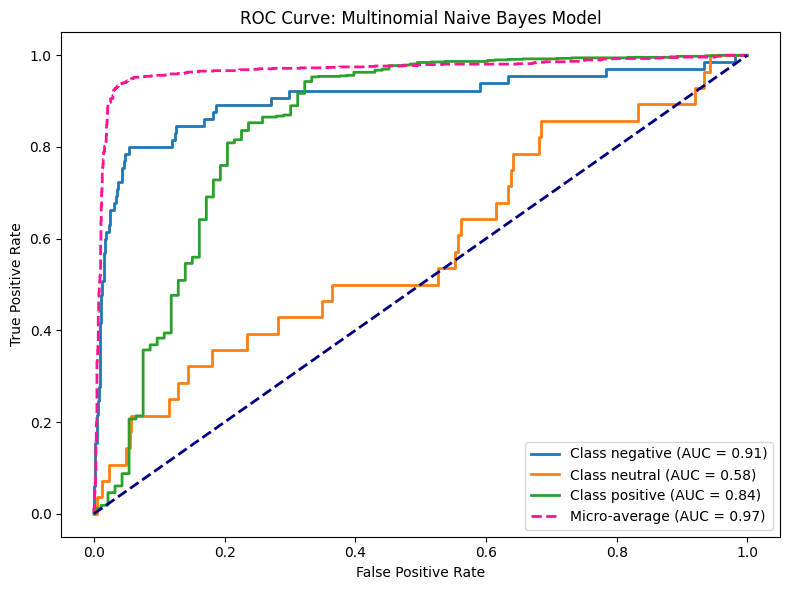

In [42]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(sorted(y_test.unique())):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], nb.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), nb.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle='--',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Multinomial Naive Bayes Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [43]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# Apply SMOTE only to the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize and train the Multinomial Naive Bayes model on the SMOTE-resampled training data
nb_smote = MultinomialNB()
nb_smote.fit(X_train_smote, y_train_smote)

nb_smote_y_pred = nb_smote.predict(X_test)
nb_smote_accuracy = accuracy_score(y_test, nb_smote_y_pred)
nb_smote_precision = precision_score(y_test, nb_smote_y_pred, average='macro')
nb_smote_recall = recall_score(y_test, nb_smote_y_pred, average='macro')
nb_smote_f1 = f1_score(y_test, nb_smote_y_pred, average='macro')
nb_smote_auc_roc = roc_auc_score(pd.get_dummies(y_test),
                                 pd.get_dummies(nb_smote_y_pred))

print("Multinomial Naive Bayes Model after SMOTE Evaluation Metrics:")
print(f'Accuracy: {nb_smote_accuracy:.4f}')
print(f'Precision: {nb_smote_precision:.4f}')
print(f'Recall: {nb_smote_recall:.4f}')
print(f'F1 Score: {nb_smote_f1:.4f}')
print(f'ROC-AUC: {nb_smote_auc_roc:.4f}')

Multinomial Naive Bayes Model after SMOTE Evaluation Metrics:
Accuracy: 0.8983
Precision: 0.5206
Recall: 0.5392
F1 Score: 0.5292
ROC-AUC: 0.6856


In [44]:
# Print the classification report using the unique_labels defined earlier
print("Classification Report for Multinomial Naive Bayes after SMOTE")
print(classification_report(y_test, nb_smote_y_pred))

Classification Report for Multinomial Naive Bayes after SMOTE
              precision    recall  f1-score   support

    negative       0.53      0.60      0.57        65
     neutral       0.07      0.07      0.07        28
    positive       0.95      0.95      0.95       890

    accuracy                           0.90       983
   macro avg       0.52      0.54      0.53       983
weighted avg       0.90      0.90      0.90       983



<Figure size 800x600 with 0 Axes>

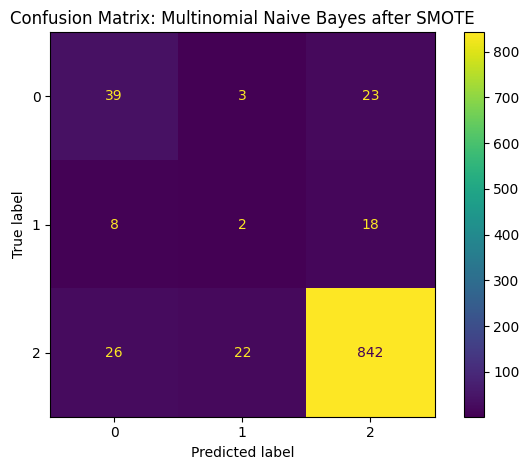

In [45]:
cm_nb_smote = confusion_matrix(y_test, nb_smote_y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb_smote)
disp.plot(values_format='d')
plt.title("Confusion Matrix: Multinomial Naive Bayes after SMOTE")
plt.grid(False)
plt.tight_layout()
plt.show()

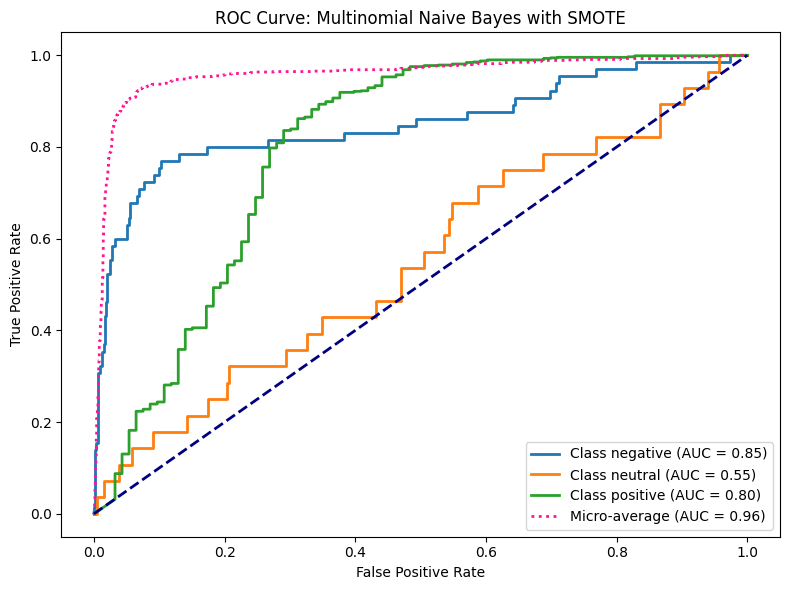

In [46]:
# Binarize the test labels for multi-class ROC curve
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))

# Plot ROC curve for each class using nb_smote model
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], nb_smote.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), nb_smote.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Multinomial Naive Bayes with SMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [47]:
# Perform ADASYN oversampling on training set only
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Initialize and train Multinomial Naive Bayes model
nb_adasyn = MultinomialNB()
nb_adasyn.fit(X_train_adasyn, y_train_adasyn)
nb_adasyn_y_pred = nb_adasyn.predict(X_test)

nb_adasyn_accuracy = accuracy_score(y_test, nb_adasyn_y_pred)
nb_adasyn_precision = precision_score(y_test, nb_adasyn_y_pred,
                                      average='macro')
nb_adasyn_recall = recall_score(y_test, nb_adasyn_y_pred,
                               average='macro')
nb_adasyn_f1 = f1_score(y_test, nb_adasyn_y_pred,
                        average='macro')
nb_adasyn_auc_roc = roc_auc_score(pd.get_dummies(y_test),
                                 pd.get_dummies(nb_adasyn_y_pred))

print("Multinomial Naive Bayes Model after ADASYN Evaluation Metrics:")
print(f'Accuracy: {nb_adasyn_accuracy:.4f}')
print(f'Precision: {nb_adasyn_precision:.4f}')
print(f'Recall: {nb_adasyn_recall:.4f}')
print(f'F1 Score: {nb_adasyn_f1:.4f}')
print(f'ROC-AUC: {nb_adasyn_auc_roc:.4f}')

Multinomial Naive Bayes Model after ADASYN Evaluation Metrics:
Accuracy: 0.8993
Precision: 0.5078
Recall: 0.5328
F1 Score: 0.5190
ROC-AUC: 0.6825


In [48]:
# Print Classification Report
print("Classification Report for Naive Bayes with ADASYN:")
print(classification_report(y_test, nb_adasyn_y_pred))

Classification Report for Naive Bayes with ADASYN:
              precision    recall  f1-score   support

    negative       0.53      0.62      0.57        65
     neutral       0.04      0.04      0.04        28
    positive       0.95      0.95      0.95       890

    accuracy                           0.90       983
   macro avg       0.51      0.53      0.52       983
weighted avg       0.90      0.90      0.90       983



<Figure size 800x600 with 0 Axes>

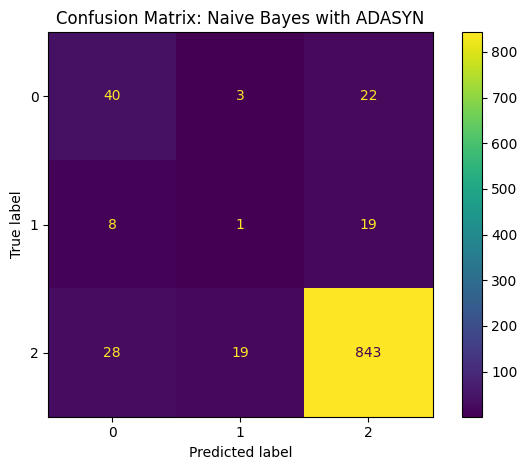

In [49]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, nb_adasyn_y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title("Confusion Matrix: Naive Bayes with ADASYN")
plt.grid(False)
plt.tight_layout()
plt.show()

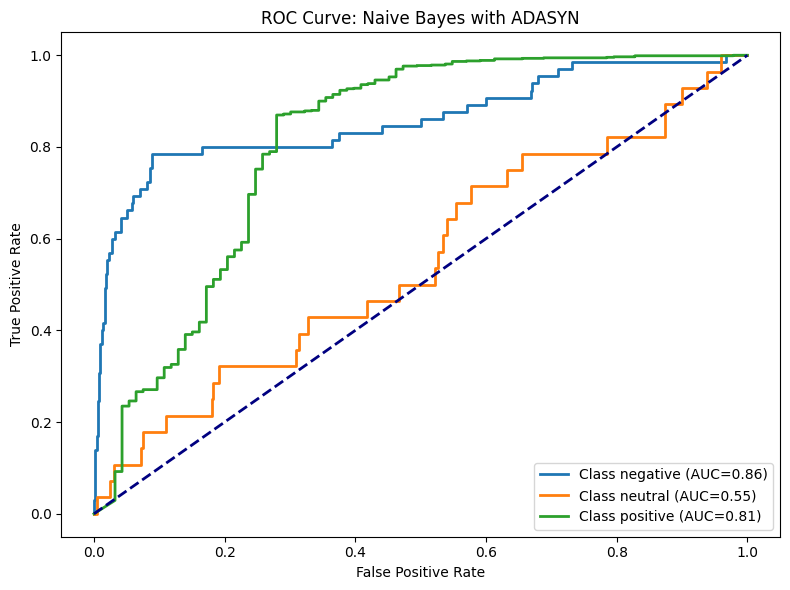

In [50]:
# Plot ROC Curve
# For multi-class ROC, we binarize the test labels
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], nb_adasyn.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve: Naive Bayes with ADASYN")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [51]:
from imblearn.over_sampling import SVMSMOTE

# Apply SVMSMOTE only on the training set
svm_smote = SVMSMOTE(random_state=42)
X_train_svm, y_train_svm = svm_smote.fit_resample(X_train, y_train)
X_train_svm = np.maximum(X_train_svm, 0)

# Initialize Multinomial Naive Bayes model
nb_svm = MultinomialNB()
nb_svm.fit(X_train_svm, y_train_svm)
nb_svm_y_pred = nb_svm.predict(X_test)

# Train and evaluate the model
nb_svm_accuracy = accuracy_score(y_test, nb_svm_y_pred)
nb_svm_precision = precision_score(y_test, nb_svm_y_pred, average='macro')
nb_svm_recall = recall_score(y_test, nb_svm_y_pred, average='macro')
nb_svm_f1 = f1_score(y_test, nb_svm_y_pred, average='macro')
nb_svm_roc_auc = roc_auc_score(pd.get_dummies(y_test),
                               pd.get_dummies(nb_svm_y_pred))

print("Multinomial Naive Bayes Model after SVMSMOTE Evaluation Metrics:")
print(f'Accuracy: {nb_svm_accuracy:.4f}')
print(f'Precision: {nb_svm_precision:.4f}')
print(f'Recall: {nb_svm_recall:.4f}')
print(f'F1 Score: {nb_svm_f1:.4f}')
print(f'ROC-AUC: {nb_svm_roc_auc:.4f}')

Multinomial Naive Bayes Model after SVMSMOTE Evaluation Metrics:
Accuracy: 0.9145
Precision: 0.5369
Recall: 0.5194
F1 Score: 0.5230
ROC-AUC: 0.6688


In [52]:
# Print classification report
print("Classification Report for Multinomial Naive Bayes Model after SVMSMOTE")
print(classification_report(y_test, nb_svm_y_pred))

Classification Report for Multinomial Naive Bayes Model after SVMSMOTE
              precision    recall  f1-score   support

    negative       0.56      0.55      0.56        65
     neutral       0.10      0.04      0.05        28
    positive       0.95      0.97      0.96       890

    accuracy                           0.91       983
   macro avg       0.54      0.52      0.52       983
weighted avg       0.90      0.91      0.91       983



<Figure size 800x600 with 0 Axes>

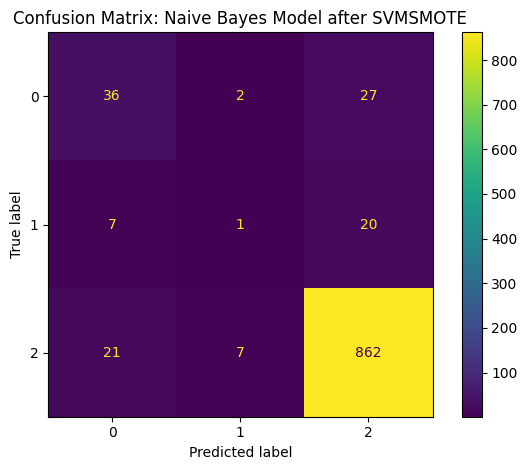

In [53]:
# Plot Confusion Matrix
cm_nb_svm = confusion_matrix(y_test, nb_svm_y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb_svm)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Naive Bayes Model after SVMSMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

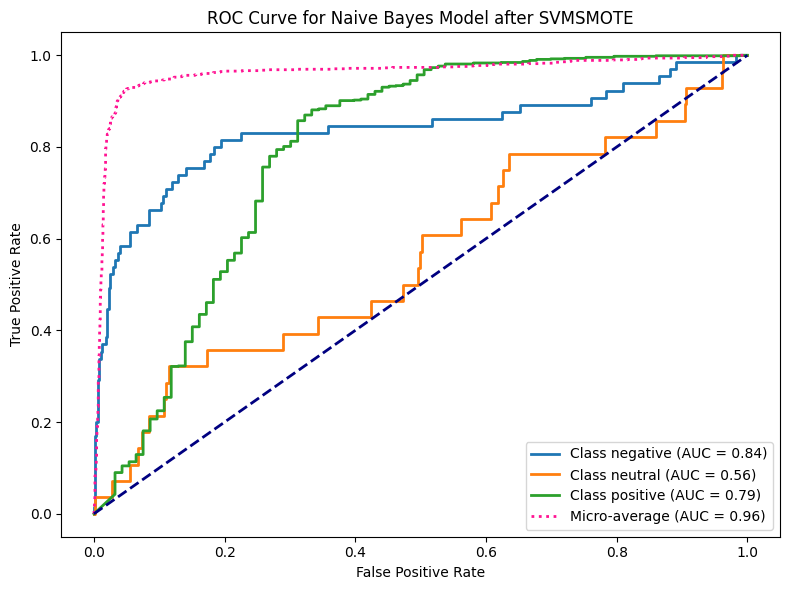

In [54]:
# Plot ROC Curve
classes_nb = sorted(y_test.unique())
y_test_binarized_nb = label_binarize(y_test, classes=classes_nb)
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes_nb):
    fpr, tpr, _ = roc_curve(y_test_binarized_nb[:, i], nb_svm.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_nb.ravel(), nb_svm.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Model after SVMSMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [55]:
# Identify categorical features (replace with actual categorical feature indices if different)
categorical_features = [i for i, col in enumerate(df.columns) if df[col].dtype == 'object']


# Initialize and train the Multinomial Naive Bayes model on the resampled data
smotenc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

nb_smotenc = MultinomialNB()
nb_smotenc.fit(X_train_smotenc, y_train_smotenc)

# Make predictions on the test set
y_pred_smotenc = nb_smotenc.predict(X_test)


# Evaluate the model
nb_smotenc_accuracy = accuracy_score(y_test, y_pred_smotenc)
nb_smotenc_precision = precision_score(y_test, y_pred_smotenc, average='macro')
nb_smotenc_recall = recall_score(y_test, y_pred_smotenc, average='macro')
nb_smotenc_f1 = f1_score(y_test, y_pred_smotenc, average='macro')
nb_smotenc_roc_auc = roc_auc_score(pd.get_dummies(y_test),
                                  pd.get_dummies(y_pred_smotenc))

print("Multinomial Naive Bayes Model after SMOTENC Evaluation Metrics:")
print(f'Accuracy: {nb_smotenc_accuracy:.4f}')
print(f'Precision: {nb_smotenc_precision:.4f}')
print(f'Recall: {nb_smotenc_recall:.4f}')
print(f'F1 Score: {nb_smotenc_f1:.4f}')
print(f'ROC-AUC: {nb_smotenc_roc_auc:.4f}')

Multinomial Naive Bayes Model after SMOTENC Evaluation Metrics:
Accuracy: 0.8983
Precision: 0.5206
Recall: 0.5392
F1 Score: 0.5292
ROC-AUC: 0.6856


In [56]:
print(classification_report(y_test, y_pred_smotenc))

              precision    recall  f1-score   support

    negative       0.53      0.60      0.57        65
     neutral       0.07      0.07      0.07        28
    positive       0.95      0.95      0.95       890

    accuracy                           0.90       983
   macro avg       0.52      0.54      0.53       983
weighted avg       0.90      0.90      0.90       983



<Figure size 800x600 with 0 Axes>

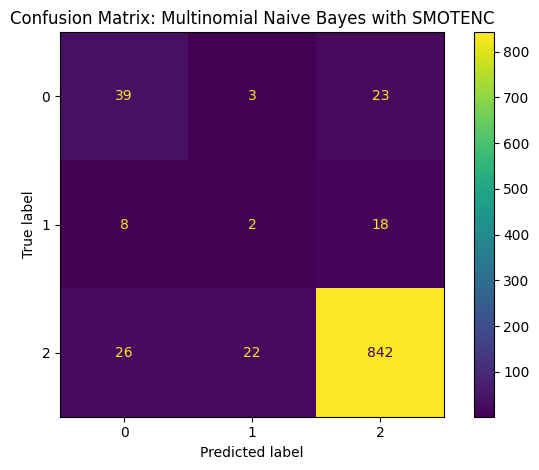

In [57]:
#Confusion Matrix
cm_smotenc = confusion_matrix(y_test, y_pred_smotenc)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smotenc)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Multinomial Naive Bayes with SMOTENC')
plt.grid(False)
plt.tight_layout()
plt.show()

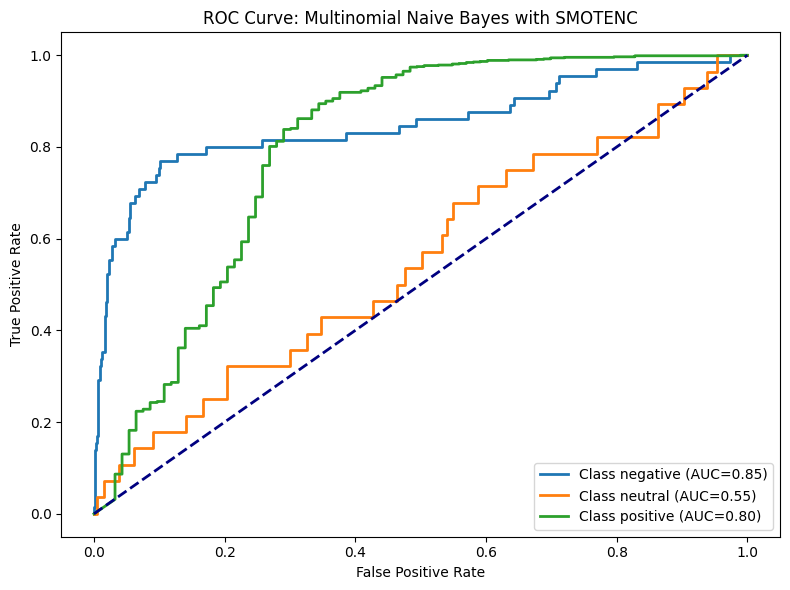

In [58]:
#ROC Curve
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
  fpr, tpr, _ = roc_curve(y_test_binarized[:, i], nb_smotenc.predict_proba(X_test)[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Multinomial Naive Bayes with SMOTENC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

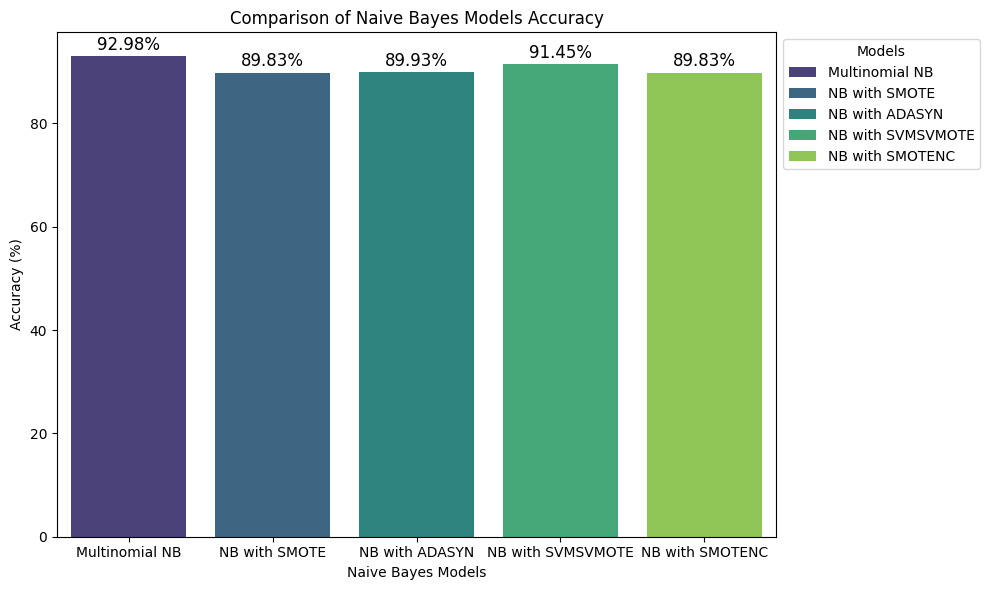

In [59]:
# Create a dataframe with model names and accuracies
models = ['Multinomial NB', 'NB with SMOTE', 'NB with ADASYN', 'NB with SVMSVMOTE', 'NB with SMOTENC']
accuracies = [nb_accuracy, nb_smote_accuracy, nb_adasyn_accuracy, nb_svm_accuracy, nb_smotenc_accuracy]

accuracy_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

plt.figure(figsize=(10,6))
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df, palette='viridis')

plt.title('Comparison of Naive Bayes Models Accuracy')
plt.xlabel('Naive Bayes Models')
plt.ylabel('Accuracy (%)')

# Annotate percentage values above each bar
for i, v in enumerate(accuracy_df['Accuracy (%)']):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontsize=12)

# Create a custom legend and place it outside the bar plot
handles = ax.patches
plt.legend(handles, models, title='Models', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [60]:
# Initialize the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

#Fit the model
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)
# Train and evaluate the model using the pre-defined train_evaluate_model function
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred, average='macro')
rf_recall = recall_score(y_test, rf_y_pred, average='macro')
rf_f1 = f1_score(y_test, rf_y_pred, average='macro')
rf_roc_auc = roc_auc_score(pd.get_dummies(y_test),
                           pd.get_dummies(rf_y_pred))

print("Random Forest Classifier Model Evaluation Metrics:")
print(f'Accuracy: {rf_accuracy:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print(f'F1 Score: {rf_f1:.4f}')
print(f'ROC-AUC: {rf_roc_auc:.4f}')

Random Forest Classifier Model Evaluation Metrics:
Accuracy: 0.9105
Precision: 0.5632
Recall: 0.3685
F1 Score: 0.3807
ROC-AUC: 0.5287


In [61]:
# Print Classification Report
print("Classification Report for Random Forest Classifier")
print(classification_report(y_test, rf_y_pred))

Classification Report for Random Forest Classifier
              precision    recall  f1-score   support

    negative       0.78      0.11      0.19        65
     neutral       0.00      0.00      0.00        28
    positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.56      0.37      0.38       983
weighted avg       0.88      0.91      0.88       983



<Figure size 800x600 with 0 Axes>

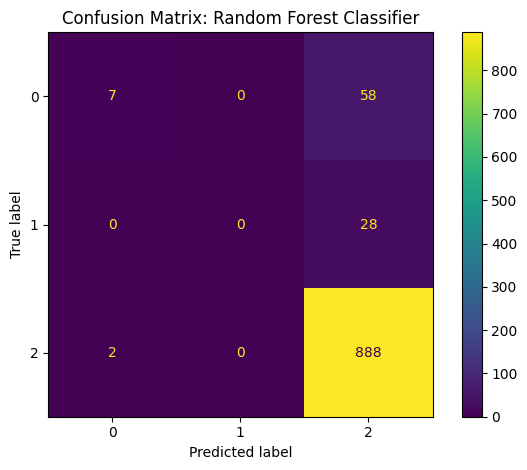

In [62]:
# Plot Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Random Forest Classifier')
plt.grid(False)
plt.tight_layout()
plt.show()

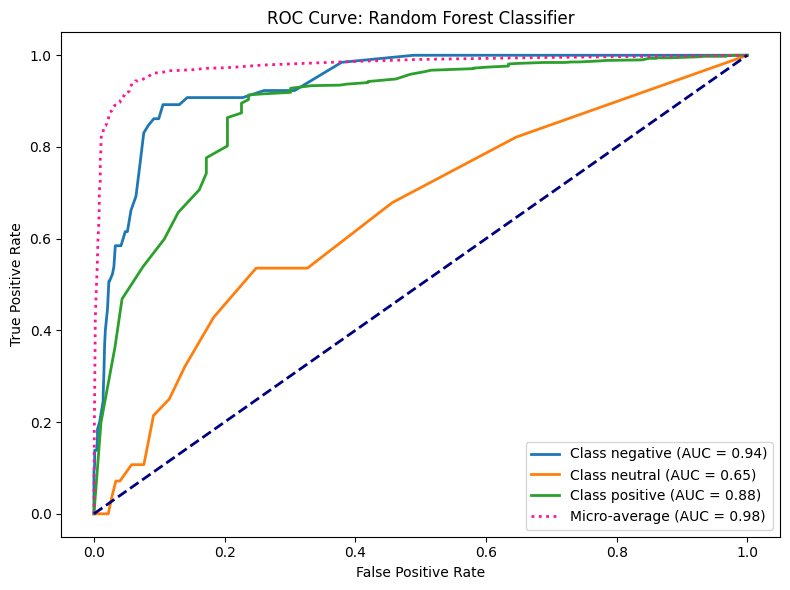

In [63]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))

# Binarize the test labels for a multi-class ROC curve
classes_rf = sorted(y_test.unique())
y_test_binarized_rf = label_binarize(y_test, classes=classes_rf)
n_classes_rf = y_test_binarized_rf.shape[1]

# Compute and plot ROC curve for each class
for i, class_label in enumerate(classes_rf):
    fpr, tpr, _ = roc_curve(y_test_binarized_rf[:, i], rf_model.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_rf.ravel(), rf_model.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Classifier')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [64]:
# Perform SMOTE only on the training set
smote_rf = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote_rf.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
rf_model_smote = RandomForestClassifier(random_state=42)

rf_model_smote.fit(X_train_smote, y_train_smote)
rf_y_pred_smote = rf_model_smote.predict(X_test)

# Train and evaluate the model using the pre-defined train_evaluate_model function
rf_accuracy_smote = accuracy_score(y_test, rf_y_pred_smote)
rf_precision_smote = precision_score(y_test, rf_y_pred_smote, average='macro')
rf_recall_smote = recall_score(y_test, rf_y_pred_smote, average='macro')
rf_f1_smote = f1_score(y_test, rf_y_pred_smote, average='macro')
rf_roc_auc_smote = roc_auc_score(pd.get_dummies(y_test),
                                 pd.get_dummies(rf_y_pred_smote))

In [65]:
# Print the classification report
print("Classification Report for Random Forest with SMOTE")
print(classification_report(y_test, rf_y_pred_smote))

Classification Report for Random Forest with SMOTE
              precision    recall  f1-score   support

    negative       0.35      0.34      0.35        65
     neutral       0.00      0.00      0.00        28
    positive       0.93      0.94      0.94       890

    accuracy                           0.88       983
   macro avg       0.43      0.43      0.43       983
weighted avg       0.87      0.88      0.87       983



<Figure size 800x600 with 0 Axes>

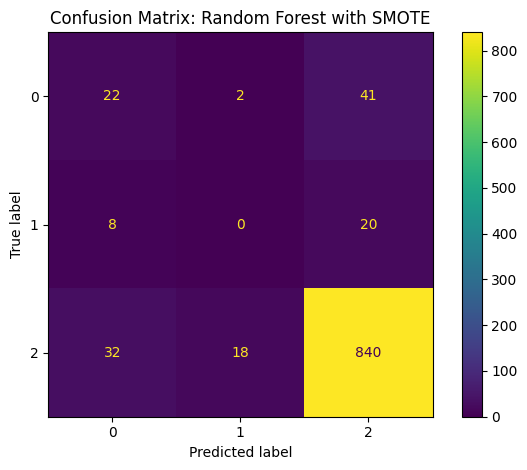

In [66]:
# Plot the confusion matrix
cm_rf_smote = confusion_matrix(y_test, rf_y_pred_smote)
plt.figure(figsize=(8, 6))
disp_rf_smote = ConfusionMatrixDisplay(confusion_matrix=cm_rf_smote)
disp_rf_smote.plot(values_format='d')
plt.title('Confusion Matrix: Random Forest with SMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

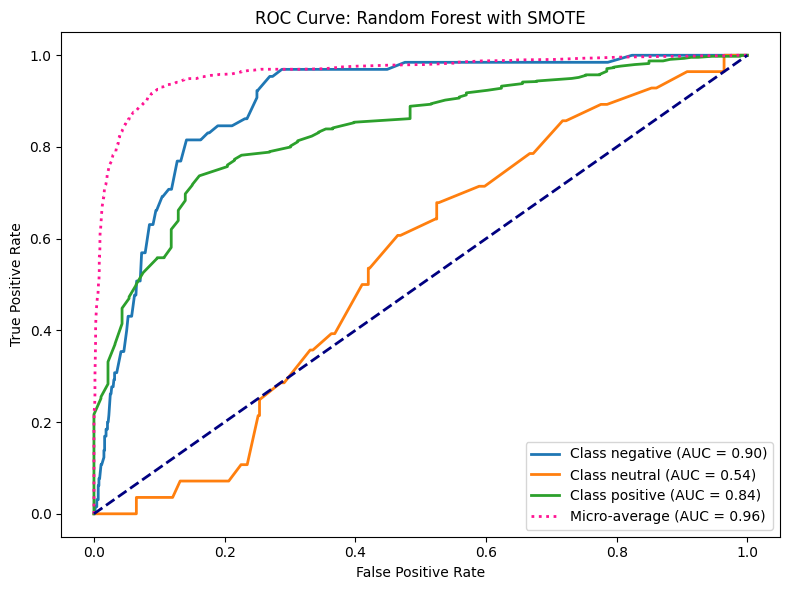

In [67]:
# Plot the ROC Curve
classes_rf = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes_rf)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_model_smote.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes_rf[i]} (AUC = {roc_auc:.2f})')

# Micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), rf_model_smote.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest with SMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [68]:
# Apply ADASYN oversampling only on the training set
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier model
rf_model_adasyn = RandomForestClassifier(random_state=42)

rf_model_adasyn.fit(X_train_adasyn, y_train_adasyn)
rf_y_pred_adasyn = rf_model_adasyn.predict(X_test)

# Train and evaluate the model using the pre-defined train_evaluate_model function
rf_accuracy_adasyn = accuracy_score(y_test, rf_y_pred_adasyn)
rf_precision_adasyn = precision_score(y_test, rf_y_pred_adasyn,
                                      average='macro')
rf_recall_adasyn = recall_score(y_test, rf_y_pred_adasyn,
                                average='macro')
rf_f1_adasyn = f1_score(y_test, rf_y_pred_adasyn,
                        average='macro')
rf_roc_auc_adasyn = roc_auc_score(pd.get_dummies(y_test),
                                  pd.get_dummies(rf_y_pred_adasyn))

In [69]:
# Print Classification Report
print("Classification Report for Random Forest Classifier after ADASYN")
print(classification_report(y_test, rf_y_pred_adasyn))

Classification Report for Random Forest Classifier after ADASYN
              precision    recall  f1-score   support

    negative       0.31      0.29      0.30        65
     neutral       0.00      0.00      0.00        28
    positive       0.93      0.94      0.94       890

    accuracy                           0.87       983
   macro avg       0.41      0.41      0.41       983
weighted avg       0.86      0.87      0.87       983



<Figure size 800x600 with 0 Axes>

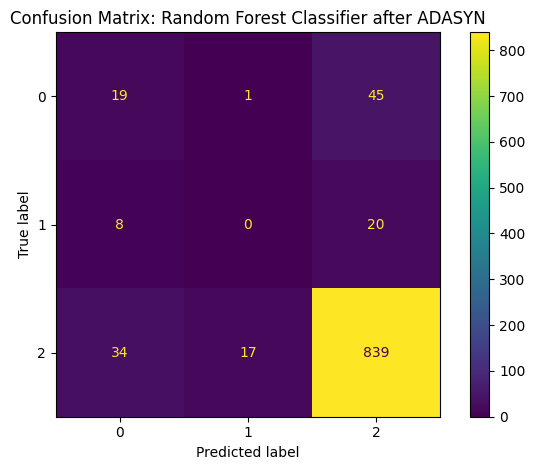

In [70]:
# Plot the Confusion Matrix
cm_rf_adasyn = confusion_matrix(y_test, rf_y_pred_adasyn)
plt.figure(figsize=(8, 6))
disp_rf_adasyn = ConfusionMatrixDisplay(confusion_matrix=cm_rf_adasyn)
disp_rf_adasyn.plot(values_format='d')
plt.title('Confusion Matrix: Random Forest Classifier after ADASYN')
plt.grid(False)
plt.tight_layout()
plt.show()

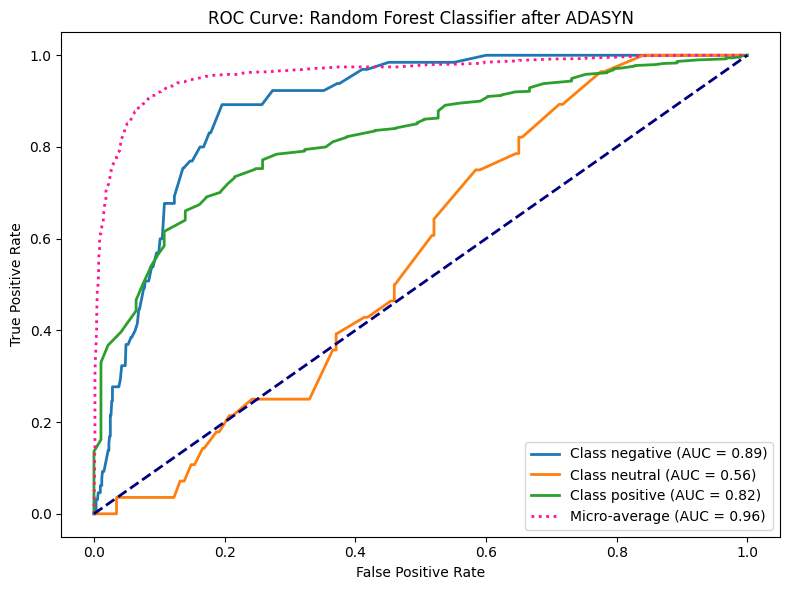

In [71]:
# Plot the ROC Curve
# Binarize y_test for multi-class ROC analysis
classes_rf = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes_rf)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes_rf):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_model_adasyn.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), rf_model_adasyn.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Classifier after ADASYN')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [72]:
from sklearn.svm import SVC

# Initialize SVC with probability=True to allow ROC curve plotting
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)
svc_y_pred = svc_model.predict(X_test)
# Train and evaluate the model using train_evaluate_model
svc_accuracy = accuracy_score(y_test, svc_y_pred)
svc_precision = precision_score(y_test, svc_y_pred, average='macro')
svc_recall = recall_score(y_test, svc_y_pred, average='macro')
svc_f1 = f1_score(y_test, svc_y_pred, average='macro')
svc_roc_auc = roc_auc_score(pd.get_dummies(y_test),
                           pd.get_dummies(svc_y_pred))

print("Support Vector Classifier Model Evaluation Metrics:")
print(f'Accuracy: {svc_accuracy:.4f}')
print(f'Precision: {svc_precision:.4f}')
print(f'Recall: {svc_recall:.4f}')
print(f'F1 Score: {svc_f1:.4f}')
print(f'ROC-AUC: {svc_roc_auc:.4f}')

Support Vector Classifier Model Evaluation Metrics:
Accuracy: 0.9115
Precision: 0.5543
Recall: 0.3641
F1 Score: 0.3729
ROC-AUC: 0.5062


In [73]:
# Print classification report
print("Classification Report for Support Vector Classifier")
print(classification_report(y_test, svc_y_pred))

Classification Report for Support Vector Classifier
              precision    recall  f1-score   support

    negative       0.75      0.09      0.16        65
     neutral       0.00      0.00      0.00        28
    positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.55      0.36      0.37       983
weighted avg       0.88      0.91      0.87       983



<Figure size 800x600 with 0 Axes>

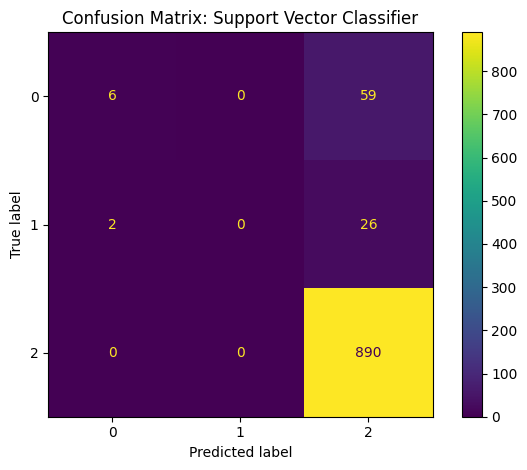

In [74]:
# Plot Confusion Matrix
cm_svc = confusion_matrix(y_test, svc_y_pred)
plt.figure(figsize=(8, 6))
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp_svc.plot(values_format='d')
plt.title('Confusion Matrix: Support Vector Classifier')
plt.grid(False)
plt.tight_layout()
plt.show()

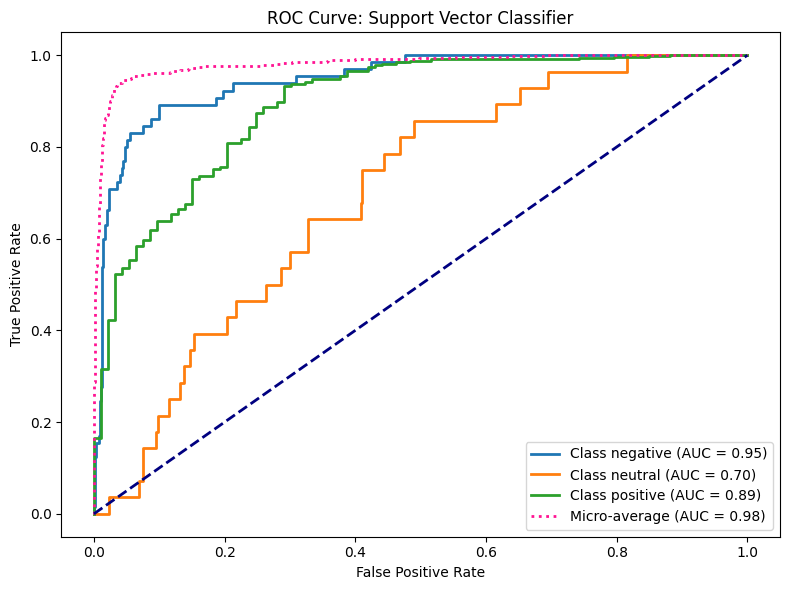

In [75]:
# Plot ROC Curve for multi-class
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svc_model.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), svc_model.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Support Vector Classifier')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [76]:
# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize Support Vector Classifier with probability=True (needed for ROC)
svc_smote = SVC(probability=True, random_state=42)
svc_smote.fit(X_train_smote, y_train_smote)
y_pred_svc_smote = svc_smote.predict(X_test)

# Train and evaluate the model on the SMOTE-resampled training set and the original test set
svc_smote_accuracy = accuracy_score(y_test, y_pred_svc_smote)
svc_smote_precision = precision_score(y_test, y_pred_svc_smote,
                                      average='macro')
svc_smote_recall = recall_score(y_test, y_pred_svc_smote, average='macro')
svc_smote_f1 = f1_score(y_test, y_pred_svc_smote, average='macro')
svc_smote_roc_auc = roc_auc_score(pd.get_dummies(y_test),
                                  pd.get_dummies(y_pred_svc_smote))

print("Support Vector Classifier Model after SMOTE Evaluation Metrics:")
print(f'Accuracy: {svc_smote_accuracy:.4f}')
print(f'Precision: {svc_smote_precision:.4f}')
print(f'Recall: {svc_smote_recall:.4f}')
print(f'F1 Score: {svc_smote_f1:.4f}')
print(f'ROC-AUC: {svc_smote_roc_auc:.4f}')

Support Vector Classifier Model after SMOTE Evaluation Metrics:
Accuracy: 0.8850
Precision: 0.4606
Recall: 0.4352
F1 Score: 0.4459
ROC-AUC: 0.5958


In [77]:
# Print the classification report
print("Classification Report: Support Vector Classifier with SMOTE")
print(classification_report(y_test, y_pred_svc_smote))

Classification Report: Support Vector Classifier with SMOTE
              precision    recall  f1-score   support

    negative       0.45      0.35      0.40        65
     neutral       0.00      0.00      0.00        28
    positive       0.93      0.95      0.94       890

    accuracy                           0.89       983
   macro avg       0.46      0.44      0.45       983
weighted avg       0.87      0.89      0.88       983



<Figure size 800x600 with 0 Axes>

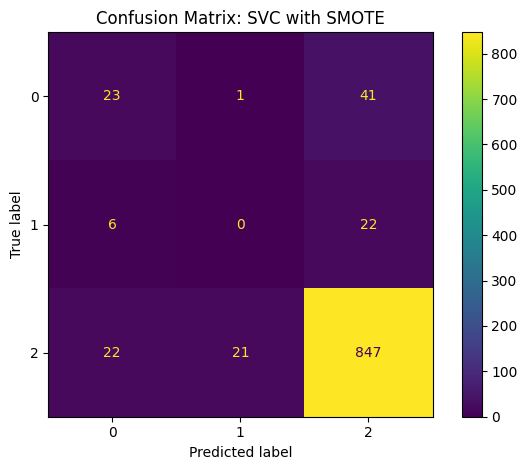

In [78]:
# Plot the confusion matrix
cm_svc_smote = confusion_matrix(y_test, y_pred_svc_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_smote)
disp.plot(values_format='d')
plt.title('Confusion Matrix: SVC with SMOTE')
plt.grid(False)
plt.tight_layout()
plt.show()

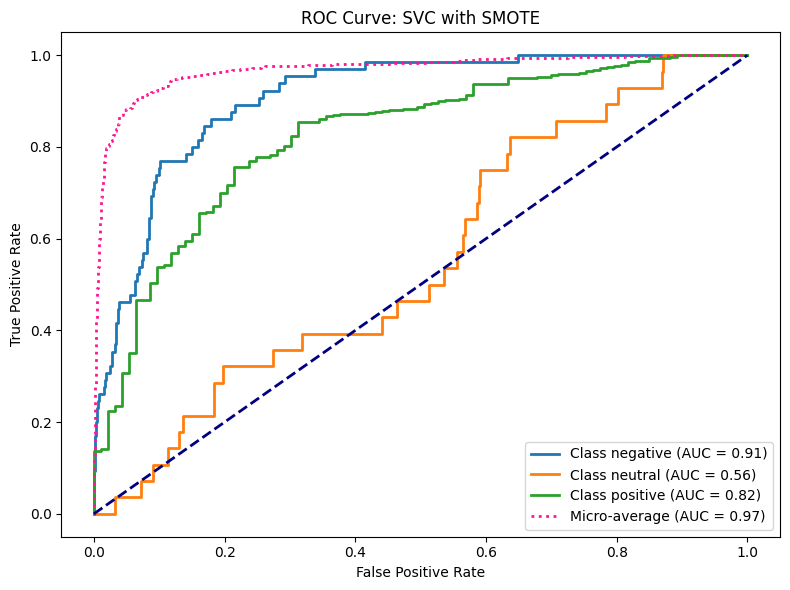

In [79]:
# Plot the ROC Curve
# Binarize the true test labels for multi-class ROC
classes_ = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes_)
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svc_smote.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), svc_smote.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVC with SMOTE')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [80]:
# Apply ADASYN oversampling on the training set only
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Initialize Support Vector Classifier with probability=True for ROC curve plotting
svc_adasyn = SVC(probability=True, random_state=42)
svc_adasyn.fit(X_train_adasyn, y_train_adasyn)
y_pred_svc_adasyn = svc_adasyn.predict(X_test)

# Train and evaluate using the pre-defined train_evaluate_model function
svc_accuracy_adasyn = accuracy_score(y_test, y_pred_svc_adasyn)
svc_precision_adasyn = precision_score(y_test, y_pred_svc_adasyn,
                                       average='macro')
svc_recall_adasyn = recall_score(y_test, y_pred_svc_adasyn, average='macro')
svc_f1_adasyn = f1_score(y_test, y_pred_svc_adasyn, average='macro')
svc_roc_auc_adasyn = roc_auc_score(pd.get_dummies(y_test),
                               pd.get_dummies(y_pred_svc_adasyn))

print('Support Vector Classifier Model after ADASYN Evaluation Metrics')
print(f'Accuracy: {svc_accuracy_adasyn:.4f}')
print(f'Precision: {svc_precision_adasyn:.4f}')
print(f'Recall: {svc_recall_adasyn:.4f}')
print(f'F1 Score: {svc_f1_adasyn:.4f}')
print(f'ROC-AUC: {svc_roc_auc_adasyn:.4f}')

Support Vector Classifier Model after ADASYN Evaluation Metrics
Accuracy: 0.8850
Precision: 0.4577
Recall: 0.4352
F1 Score: 0.4448
ROC-AUC: 0.5958


In [81]:
# Print the classification report
print("Classification Report for SVC with ADASYN")
print(classification_report(y_test, y_pred_svc_adasyn))

Classification Report for SVC with ADASYN
              precision    recall  f1-score   support

    negative       0.44      0.35      0.39        65
     neutral       0.00      0.00      0.00        28
    positive       0.93      0.95      0.94       890

    accuracy                           0.89       983
   macro avg       0.46      0.44      0.44       983
weighted avg       0.87      0.89      0.88       983



<Figure size 800x600 with 0 Axes>

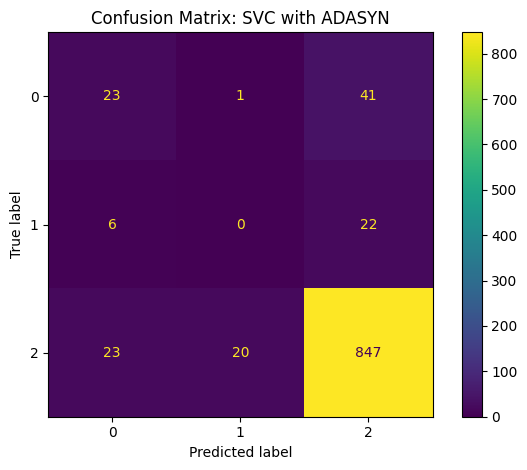

In [82]:
# Plot the confusion matrix
cm_svc_adasyn = confusion_matrix(y_test, y_pred_svc_adasyn)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_adasyn)
disp.plot(values_format='d')
plt.title("Confusion Matrix: SVC with ADASYN")
plt.grid(False)
plt.tight_layout()
plt.show()

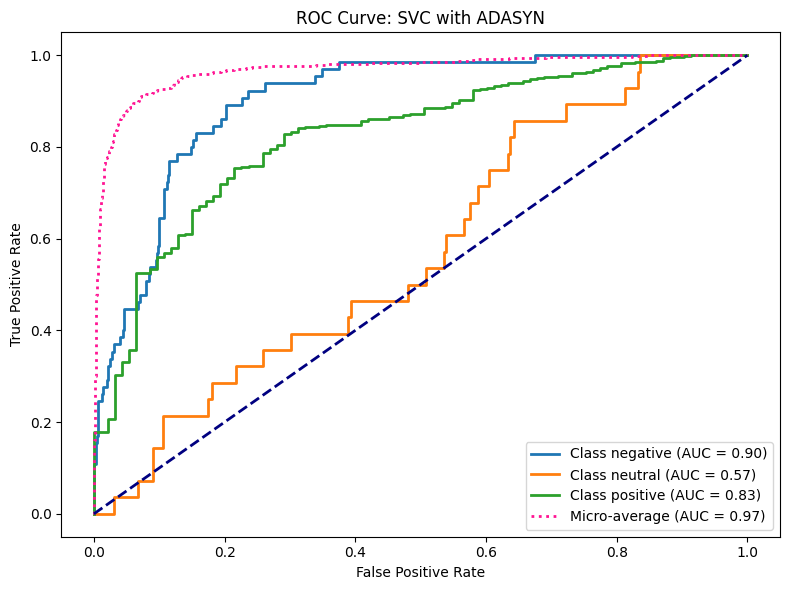

In [83]:
# Plot the ROC Curve for multi-class classification
plt.figure(figsize=(8, 6))
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svc_adasyn.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), svc_adasyn.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVC with ADASYN')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [84]:
# Apply SVMSMOTE to the training set only
svm_smote = SVMSMOTE(random_state=42)
X_train_smote, y_train_smote = svm_smote.fit_resample(X_train, y_train)

# Initialize Support Vector Classifier
svc_model_smote = SVC(probability=True, random_state=42)
svc_model_smote.fit(X_train_smote, y_train_smote)
y_pred_svc_smote = svc_model_smote.predict(X_test)

# Train and evaluate the model using the pre-defined function
svc_smote_accuracy = accuracy_score(y_test, y_pred_svc_smote)
svc_smote_precision = precision_score(y_test, y_pred_svc_smote,
                                      average='macro')
svc_smote_recall = recall_score(y_test, y_pred_svc_smote,
                                average='macro')
svc_smote_f1 = f1_score(y_test, y_pred_svc_smote, average='macro')
svc_smote_auc_roc = roc_auc_score(pd.get_dummies(y_test),
                                  pd.get_dummies(y_pred_svc_smote))

print("Support Vector Classifier Model after SVMSMOTE Evaluation Metrics:")
print(f'Accuracy: {svc_smote_accuracy:.4f}')
print(f'Precision: {svc_smote_precision:.4f}')
print(f'Recall: {svc_smote_recall:.4f}')
print(f'F1 Score: {svc_smote_f1:.4f}')
print(f'ROC-AUC: {svc_smote_auc_roc:.4f}')

Support Vector Classifier Model after SVMSMOTE Evaluation Metrics:
Accuracy: 0.8983
Precision: 0.4945
Recall: 0.4638
F1 Score: 0.4767
ROC-AUC: 0.6172


In [85]:
# Print Classification Report
print("Classification Report for Support Vector Classifier after SVMSMOTE")
print(classification_report(y_test, y_pred_svc_smote))

Classification Report for Support Vector Classifier after SVMSMOTE
              precision    recall  f1-score   support

    negative       0.55      0.43      0.48        65
     neutral       0.00      0.00      0.00        28
    positive       0.93      0.96      0.95       890

    accuracy                           0.90       983
   macro avg       0.49      0.46      0.48       983
weighted avg       0.88      0.90      0.89       983



<Figure size 800x600 with 0 Axes>

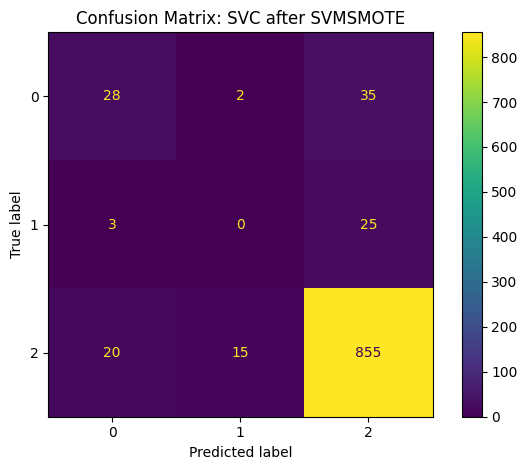

In [86]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svc_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title("Confusion Matrix: SVC after SVMSMOTE")
plt.grid(False)
plt.tight_layout()
plt.show()

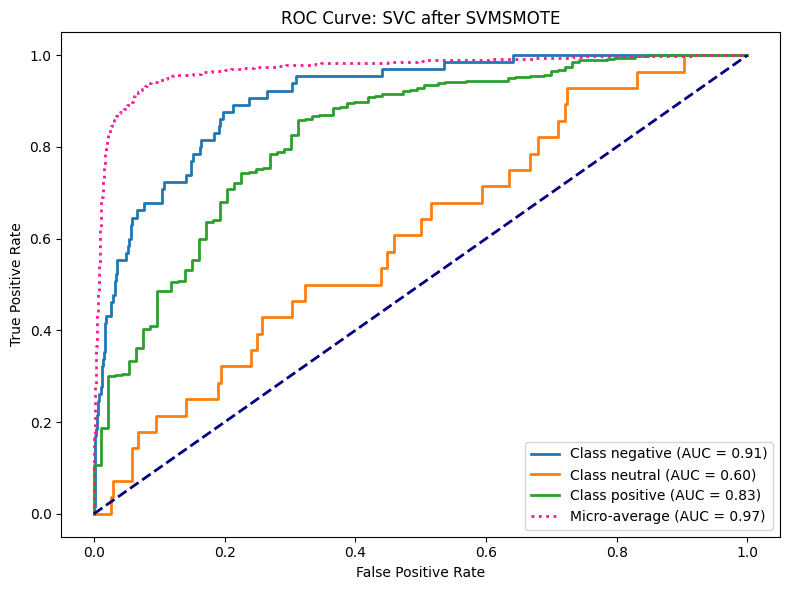

In [87]:
# Plot ROC Curve
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svc_model_smote.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Compute and plot micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), svc_model_smote.predict_proba(X_test).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve: SVC after SVMSMOTE")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

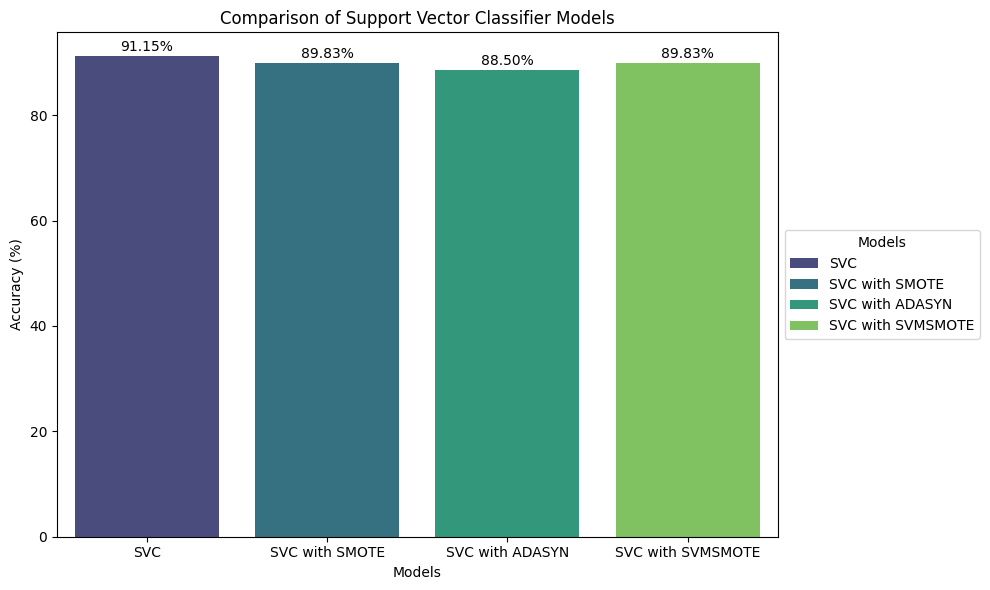

In [88]:
# Create a DataFrame for SVC model comparison
models = ['SVC', 'SVC with SMOTE', 'SVC with ADASYN', 'SVC with SVMSMOTE']
accuracy_scores = [svc_accuracy, svc_smote_accuracy, svc_accuracy_adasyn, svc_smote_accuracy]
accuracy_df = pd.DataFrame({'Model': models, 'Accuracy': accuracy_scores})
accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

# Plot the bar plot with annotations on top and legend outside
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df, palette='viridis')
plt.title('Comparison of Support Vector Classifier Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Annotate percentage values above each bar
for i, row in accuracy_df.iterrows():
    ax.text(i, row['Accuracy (%)'] + 0.5, f"{row['Accuracy (%)']:.2f}%", ha='center', va='bottom', fontsize=10)

# Create custom legend outside of the plot
handles = ax.patches
plt.legend(handles, models, title='Models', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [89]:
# Class count
count_class_0, count_class_1, count_class_2 = df['type'].value_counts()

# Divide by class
df_class_0 = df[df['type'] == 'positive']
df_class_1 = df[df['type'] == 'neutral']
df_class_2 = df[df['type'] == 'negative']

# Random oversampling
df_class_2_over = df_class_2.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1, df_class_2_over], axis=0)

# Assuming 'lower' column contains the preprocessed text data
X = cv.fit_transform(df_test_over['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df_test_over['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y, shuffle=True)

X_train_lstm = np.array(X_train)
X_test_lstm = np.array(X_test)
y_train_lstm = np.array(y_train)
y_test_lstm = np.array(y_test)
# Reshape the input data to be 3D [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],
                                    X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],
                                  X_test_lstm.shape[1], 1)

# Encode string labels into numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the number of classes
num_classes = len(np.unique(y_train_encoded))
# Convert the labels to categorical format
y_train_lstm = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_encoded, num_classes=num_classes)


# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5000, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,483 (501.89 KB)

 Trainable params: 128,483 (501.89 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10,
                    batch_size=64, validation_data=(X_test_lstm,
                                                    y_test_lstm))
# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate Metrics for LSTM using MSE, RMSE, MAE, and R2 Score
lstm_mse = np.mean((y_test_lstm - model.predict(X_test_lstm))**2)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = np.mean(np.abs(y_test_lstm - model.predict(X_test_lstm)))
lstm_r2 = 1 - (np.sum((y_test_lstm - model.predict(X_test_lstm))**2) / np.sum((y_test_lstm - np.mean(y_test_lstm))**2))
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM R2 Score: {lstm_r2:.4f}")

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.4765 - loss: 0.8744 - val_accuracy: 0.4920 - val_loss: 0.7652
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - accuracy: 0.4901 - loss: 0.7781 - val_accuracy: 0.4920 - val_loss: 0.7645
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 452ms/step - accuracy: 0.5003 - loss: 0.7697 - val_accuracy: 0.4920 - val_loss: 0.7654
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.4894 - loss: 0.7751 - val_accuracy: 0.4920 - val_loss: 0.7652
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - accuracy: 0.4895 - loss: 0.7669 - val_accuracy: 0.4920 - val_loss: 0.7643
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - accuracy: 0.4822 - loss: 0.7710 - val_accuracy: 0.4920 - val_loss: 0.7644
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.5096 - loss: 0.7627 - val_accuracy: 0.4920 - val_loss: 0.7644
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 452ms/step - accuracy: 0.4849 - loss: 0

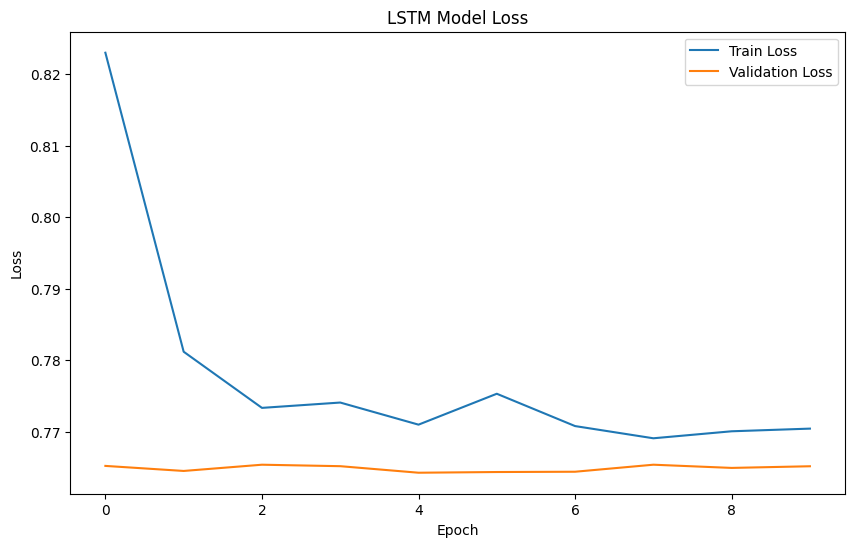

In [91]:
# Plot LSTM validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [92]:
# Print classification report of LSTM model
y_pred_lstm = np.argmax(model.predict(X_test_lstm), axis=-1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=-1)
print(classification_report(y_test_lstm_labels, y_pred_lstm))

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       889
           1       0.00      0.00      0.00        29
           2       0.49      1.00      0.66       889

    accuracy                           0.49      1807
   macro avg       0.16      0.33      0.22      1807
weighted avg       0.24      0.49      0.32      1807



<Figure size 800x600 with 0 Axes>

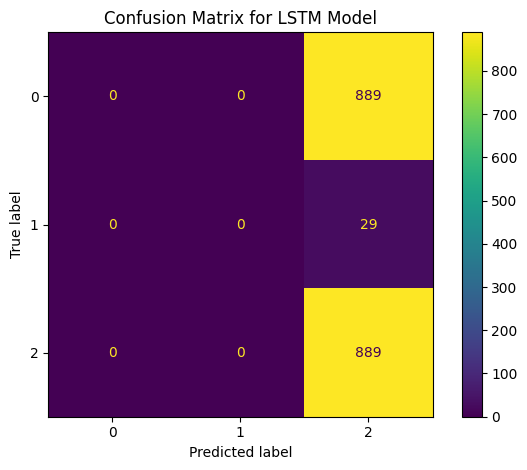

In [93]:
# Confusion Matrix LSTM
cm = confusion_matrix(y_test_lstm_labels, y_pred_lstm)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix for LSTM Model')
plt.tight_layout()
plt.grid(False)
plt.show()

In [94]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled, shuffle=True)

# Convert to numpy arrays and reshape for LSTM
X_train_lstm = np.array(X_train)
X_test_lstm = np.array(X_test)
y_train_lstm = np.array(y_train)
y_test_lstm = np.array(y_test)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Encode labels and convert to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train_encoded))
y_train_lstm = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_encoded, num_classes=num_classes)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 5000, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,483 (501.89 KB)

 Trainable params: 128,483 (501.89 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10,
                    batch_size=64, validation_data=(X_test_lstm,
                                                    y_test_lstm))
# Evaluate the model
lstm_loss_ros, lstm_accuracy_ros = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate Metrics for LSTM using MSE, RMSE, MAE, and R2 Score
lstm_mse = np.mean((y_test_lstm - model.predict(X_test_lstm))**2)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = np.mean(np.abs(y_test_lstm - model.predict(X_test_lstm)))
lstm_r2 = 1 - (np.sum((y_test_lstm - model.predict(X_test_lstm))**2) / np.sum((y_test_lstm - np.mean(y_test_lstm))**2))
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM R2 Score: {lstm_r2:.4f}")

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 473ms/step - accuracy: 0.3384 - loss: 1.1002 - val_accuracy: 0.3906 - val_loss: 1.0916
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 79s 470ms/step - accuracy: 0.3534 - loss: 1.1125 - val_accuracy: 0.3332 - val_loss: 1.0987
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 467ms/step - accuracy: 0.3455 - loss: 1.0983 - val_accuracy: 0.3332 - val_loss: 1.0978
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 79s 448ms/step - accuracy: 0.3425 - loss: 1.0976 - val_accuracy: 0.3400 - val_loss: 1.0970
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 451ms/step - accuracy: 0.3391 - loss: 1.0972 - val_accuracy: 0.3321 - val_loss: 1.0969
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 468ms/step - accuracy: 0.3287 - loss: 1.0973 - val_accuracy: 0.3310 - val_loss: 1.0954
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 469ms/step - accuracy: 0.3450 - loss: 1.0951 - val_accuracy: 0.3096 - val_loss: 1.0956
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 470ms/step - accuracy: 0.3396 - loss: 1

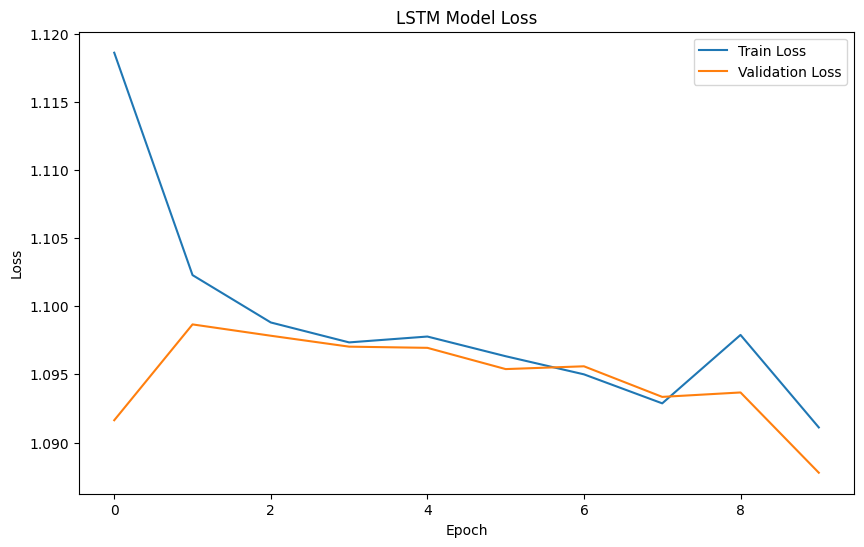

In [96]:
# Plot LSTM validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [97]:
# Print classification report of LSTM model
y_pred_lstm = np.argmax(model.predict(X_test_lstm), axis=-1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=-1)
print(classification_report(y_test_lstm_labels, y_pred_lstm))

84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step
              precision    recall  f1-score   support

           0       0.47      0.29      0.36       889
           1       0.00      0.00      0.00       889
           2       0.37      0.87      0.52       890

    accuracy                           0.39      2668
   macro avg       0.28      0.39      0.29      2668
weighted avg       0.28      0.39      0.29      2668



<Figure size 800x600 with 0 Axes>

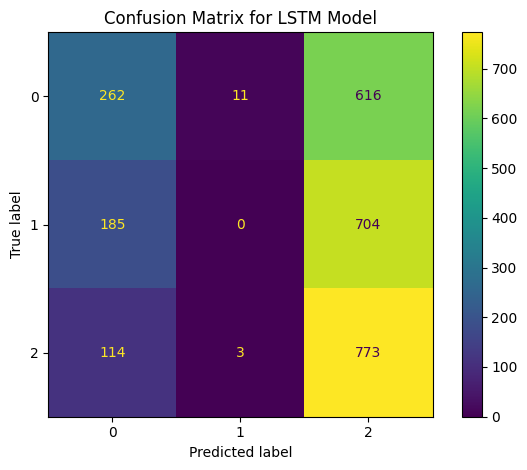

In [98]:
# Confusion Matrix LSTM
cm = confusion_matrix(y_test_lstm_labels, y_pred_lstm)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix for LSTM Model')
plt.tight_layout()
plt.grid(False)
plt.show()

In [99]:
X_train_gru = np.array(X_train)
X_test_gru = np.array(X_test)
y_train_gru = np.array(y_train)
y_test_gru = np.array(y_test)

# Reshape the input data
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0],
                                  X_train_gru.shape[1], 1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0],
                                X_test_gru.shape[1], 1)

# Encode string in categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the num_classes
num_classes = len(np.unique(y_train_encoded))
# Convert the labels to categorical format
y_train_gru = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_gru = to_categorical(y_test_encoded, num_classes=num_classes)

# Define GRU model architecture
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(X_train_gru.shape[1], 1),
                  return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5000, 128)      │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5000, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,059 (379.14 KB)

 Trainable params: 97,059 (379.14 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
gru_history = gru_model.fit(X_train_gru, y_train_gru, epochs=10,
                        batch_size=64,
                        validation_data=(X_test_gru, y_test_gru))

# Evaluate the model
gru_loss, gru_accuracy = gru_model.evaluate(X_test_gru, y_test_gru, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluation Metrics
gru_mse = np.mean((y_test_gru - gru_model.predict(X_test_gru))**2)
gru_rmse = np.sqrt(gru_mse)
gru_mae = np.mean(np.abs(y_test_gru - gru_model.predict(X_test_gru)))
gru_r2 = 1 - (np.sum((y_test_gru - gru_model.predict(X_test_gru))**2) / np.sum((y_test_gru - np.mean(y_test_gru))**2))

print(f"GRU Model")
print("===========")
print(f"GRU MSE: {gru_mse:.4f}")
print(f"GRU RMSE: {gru_rmse:.4f}")
print(f"GRU MAE: {gru_mae:.4f}")
print(f"GRU R2 Score: {gru_r2:.4f}")

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 75s 436ms/step - accuracy: 0.3295 - loss: 1.0997 - val_accuracy: 0.3347 - val_loss: 1.0989
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 85s 456ms/step - accuracy: 0.3393 - loss: 1.0997 - val_accuracy: 0.3332 - val_loss: 1.0976
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 435ms/step - accuracy: 0.3331 - loss: 1.0987 - val_accuracy: 0.3422 - val_loss: 1.0966
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 455ms/step - accuracy: 0.3260 - loss: 1.0981 - val_accuracy: 0.3332 - val_loss: 1.0952
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.3428 - loss: 1.0959 - val_accuracy: 0.3478 - val_loss: 1.0939
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.3353 - loss: 1.0941 - val_accuracy: 0.3430 - val_loss: 1.0944
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 454ms/step - accuracy: 0.3461 - loss: 1.0944 - val_accuracy: 0.3426 - val_loss: 1.0934
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 73s 434ms/step - accuracy: 0.3493 - loss: 1

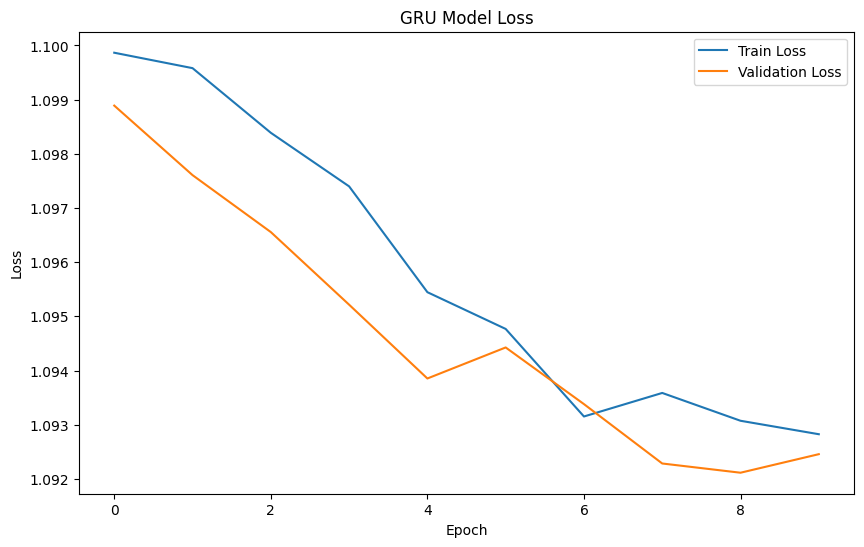

In [101]:
# Plot validation loss of GRU
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [102]:
# Print classification report of GRU
y_pred_gru = np.argmax(gru_model.predict(X_test_gru), axis=-1)
y_test_gru_labels = np.argmax(y_test_gru, axis=-1)
print(classification_report(y_test_gru_labels, y_pred_gru))

84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step
              precision    recall  f1-score   support

           0       0.52      0.07      0.12       889
           1       0.00      0.00      0.00       889
           2       0.34      0.96      0.50       890

    accuracy                           0.34      2668
   macro avg       0.29      0.34      0.21      2668
weighted avg       0.29      0.34      0.21      2668



<Figure size 800x600 with 0 Axes>

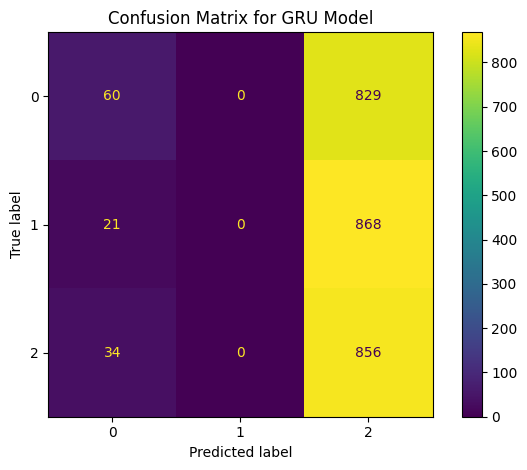

In [103]:
# Confusion Matrix on GRU Model
cm = confusion_matrix(y_test_gru_labels, y_pred_gru)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix for GRU Model')
plt.tight_layout()
plt.grid(False)
plt.show()

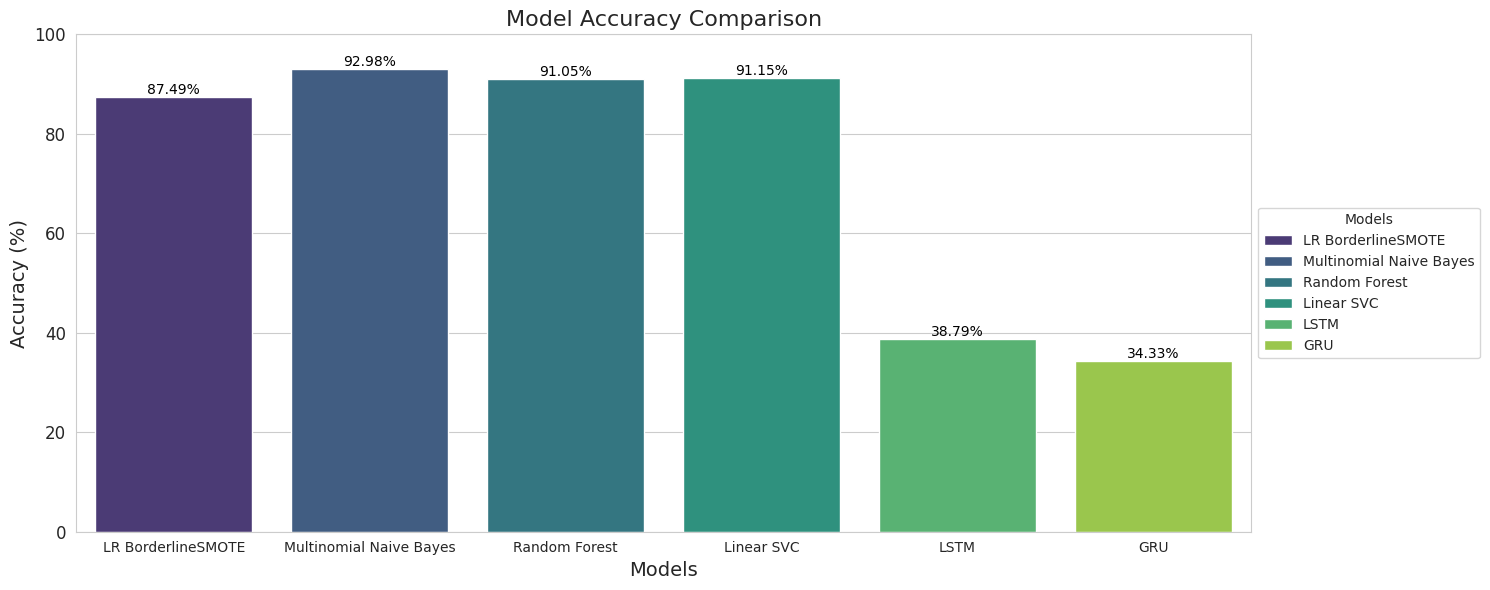

In [104]:
model_accuracies = {
    'LR BorderlineSMOTE': lr_accuracy_borderline_smote,
    'Multinomial Naive Bayes': nb_accuracy,
    'Random Forest': rf_accuracy,
    'Linear SVC': svc_accuracy,
    'LSTM': lstm_accuracy_ros,
    'GRU': gru_accuracy
}

# Convert the dictionary to a DataFrame for easier plotting
accuracy_df = pd.DataFrame({'Model': list(model_accuracies.keys()),
                            'Accuracy': list(model_accuracies.values())})

# Calculate percentage for each model's accuracy
accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

# Create the figure and axes object
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

# Create the bar plot with assigned colors
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df,
                 palette='viridis', dodge=False)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=10, ha='center')
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Add percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
     (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')


# Get the handles and labels for the legend
handles = ax.patches  # Get the bar objects directly
labels = accuracy_df['Model'].tolist()  # Get model names for labels

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models',
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Twitter Sentiment Analysis
## Introduction

In this project, we will be performing sentiment analysis on tweets from Twitter using the Tweepy library in Python. We will be using the TextBlob library to perform sentiment analysis on the tweets.

In [ ]:
# Loading the data in .txt
test = pd.read_table('/content/drive/MyDrive/ali hamza/test_62k.txt')
train = pd.read_table('/content/drive/MyDrive/ali hamza/train_150k.txt')

train.head()

,0,Starting back at work today Looks like it'll be raining for the next couple of days
0,1,Sugar levels dropping... munchies setting in. ...
1,1,@karineb22 yeah!!! have a great summer break!
2,1,hannah montana was very good. now going to re...
3,1,"@Mayra326 aww, have fun! I just had my 3D las..."
4,0,Worried about my cat. Took him to the vet and ...


In [ ]:
test.head()

,1,"@justineville ...yeahhh. ) i'm 39 tweets from 1,600!"
0,0,@ApplesnFeathers aww. Poor baby! On your only ...
1,0,@joeymcintyre With my refunded $225 (Australia...
2,0,It's fine. Today sucks just because me those t...
3,0,"Im just chilling on psp and stuff, but sitting..."
4,0,@lisarinna very sad Lisa...she is freeeeeeeeee...


In [ ]:
train.shape, test.shape

((149984, 2), (61997, 2))

In [ ]:
# Rename columns for train and test DataFrames
train.columns = ['N', 'text']
test.columns = ['N', 'text']

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

Training Data:


,N,text
0,1,Sugar levels dropping... munchies setting in. ...
1,1,@karineb22 yeah!!! have a great summer break!
2,1,hannah montana was very good. now going to re...
3,1,"@Mayra326 aww, have fun! I just had my 3D las..."
4,0,Worried about my cat. Took him to the vet and ...


In [ ]:
train['N'].value_counts()

,count
N,
0,75018
1,74966


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149984 entries, 0 to 149983
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   N       149984 non-null  int64 
 1   text    149984 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,@ApplesnFeathers aww. Poor baby! On your only ...
1,0,@joeymcintyre With my refunded $225 (Australia...
2,0,It's fine. Today sucks just because me those t...
3,0,"Im just chilling on psp and stuff, but sitting..."
4,0,@lisarinna very sad Lisa...she is freeeeeeeeee...


In [ ]:
test['N'].value_counts()

,count
N,
1,31028
0,30969


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61997 entries, 0 to 61996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N       61997 non-null  int64 
 1   text    61997 non-null  object
dtypes: int64(1), object(1)
memory usage: 968.8+ KB


In [ ]:
# Preprocessing on text column of both train and test DataFrames using a define function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Apply the preprocess_text function to the 'text' column of both DataFrames
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

Training Data:


,N,text
0,1,sugar levels dropping munchies setting in luck...
1,1,karineb yeah have a great summer break
2,1,hannah montana was very good now going to rea...
3,1,mayra aww have fun i just had my d last week
4,0,worried about my cat took him to the vet and h...


In [ ]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,applesnfeathers aww poor baby on your only rea...
1,0,joeymcintyre with my refunded australian tick...
2,0,its fine today sucks just because me those thi...
3,0,im just chilling on psp and stuff but sitting ...
4,0,lisarinna very sad lisashe is freeeeeeeeeeee a...


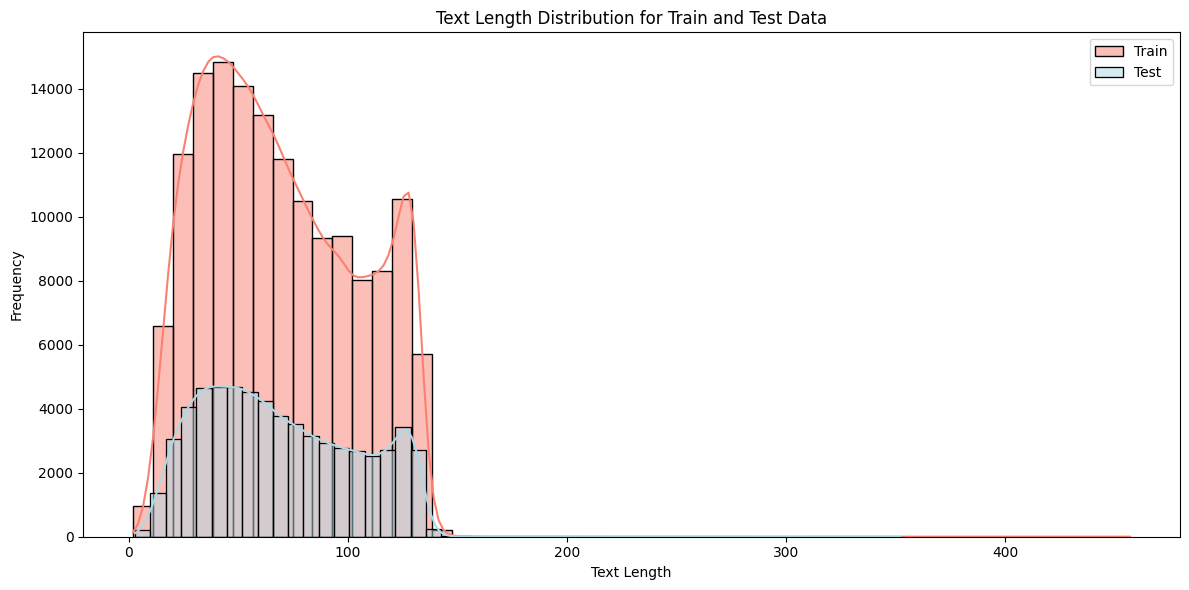

In [ ]:
# Visualize the text length distribution for both train and test DataFrames
plt.figure(figsize=(12, 6))
sns.histplot(train['text'].apply(len), color='salmon', bins=50, kde=True, label='Train')
sns.histplot(test['text'].apply(len), color='lightblue', bins=50, kde=True, label='Test')
plt.title('Text Length Distribution for Train and Test Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

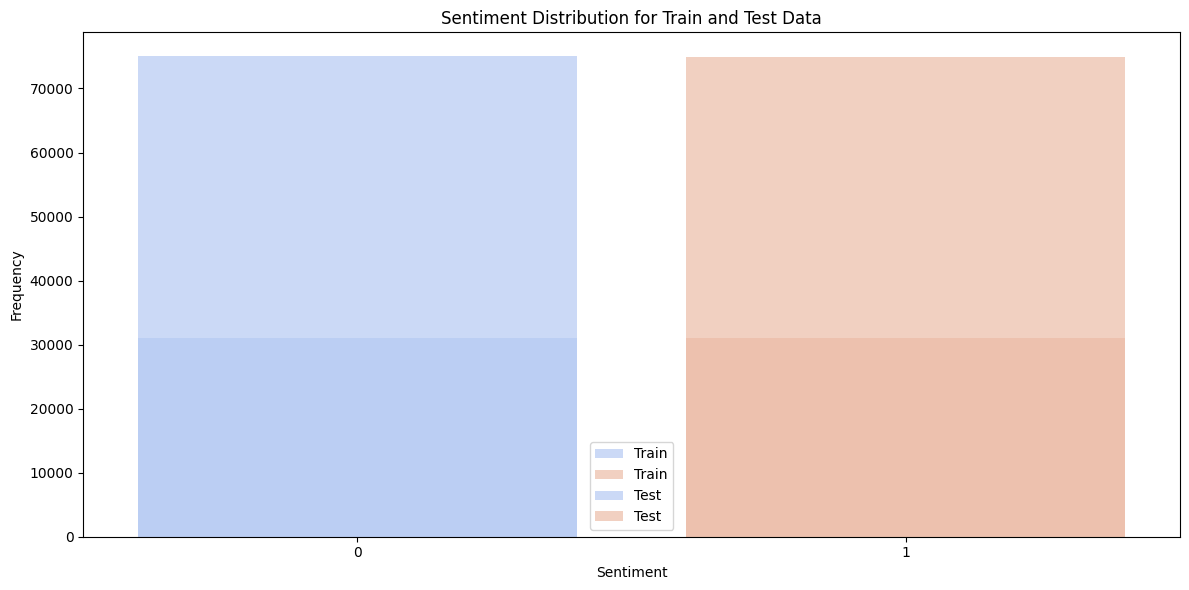

In [ ]:
# Visualize the text column based on the sentiment for both train and test DataFrames
plt.figure(figsize=(12, 6))
sns.countplot(x='N', data=train, palette='coolwarm', label='Train', alpha=0.7)
sns.countplot(x='N', data=test, palette='coolwarm', label='Test', alpha=0.7)
plt.title('Sentiment Distribution for Train and Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column for both train and test DataFrames
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

# Apply the preprocess_text function to the 'text' column of both DataFrames
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Training Data:


,N,text
0,1,"[sugar, level, drop, munchi, set, luckili, bla..."
1,1,"[karineb, yeah, great, summer, break]"
2,1,"[hannah, montana, good, go, read, twilight]"
3,1,"[mayra, aww, fun, last, week]"
4,0,"[worri, cat, took, vet, blood, work, etc, norm..."


In [ ]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,"[applesnfeath, aww, poor, babi, real, day]"
1,0,"[joeymcintyr, refund, australian, ticket, pric..."
2,0,"[fine, today, suck, thing, dunno, see]"
3,0,"[im, chill, psp, stuff, sit, pc, also, watch, ..."
4,0,"[lisarinna, sad, lisash, freeeeeeeeeeee, angel..."


In [ ]:
# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(train['text'].apply(lambda x: ' '.join(x))).toarray()
y_train = train['N']
X_test = cv.transform(test['text'].apply(lambda x: ' '.join(x))).toarray()
y_test = test['N']

# Initialize Linear Regression model
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, verbose=1, solver='liblinear', C=0.1)

# Train and evaluate the model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Display the evaluation metrics
lr_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Logistic Regression Model')
print('-------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

[LibLinear]Logistic Regression Model
-------------------------
Accuracy: 0.7328419117054051
Precision: 0.7500987811920611
Recall: 0.7953783679257445
F1 Score: 0.7720752710037698
AUC-ROC: 0.7649435350881911


---------------------- Confusion Matrix for Logistic Regression Model ----------------------


<Figure size 800x600 with 0 Axes>

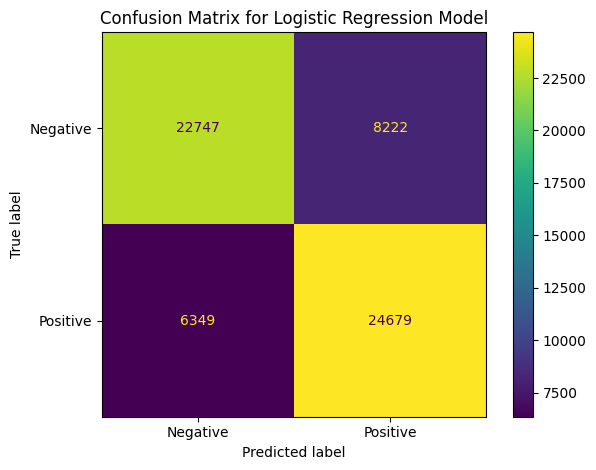

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix for Logistic Regression model
cm = confusion_matrix(y_test, lr.predict(X_test))
print('---------------------- Confusion Matrix for Logistic Regression Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

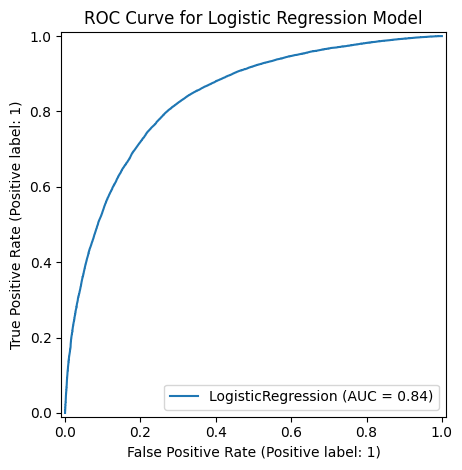

In [ ]:
from sklearn.metrics import RocCurveDisplay

# Plot the ROC curve for Logistic Regression model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr, X_test, y_test)

plt.title('ROC Curve for Logistic Regression Model')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for Logistic Regression model
print('---------------------- Classification Report of Logistic Regression Model ----------------------')
print(classification_report(y_test, lr.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Logistic Regression Model ----------------------
              precision    recall  f1-score   support

    Negative       0.78      0.73      0.76     30969
    Positive       0.75      0.80      0.77     31028

    accuracy                           0.76     61997
   macro avg       0.77      0.76      0.76     61997
weighted avg       0.77      0.76      0.76     61997

------------------------------------------------------------


In [ ]:
# Initialize Multinomial Naive Bayes model
nb = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)

# Train and evaluate the model
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Display the evaluation metrics
mnb_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Multinomial Naive Bayes Model')
print('-----------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

Multinomial Naive Bayes Model
-----------------------------
Accuracy: 0.7328419117054051
Precision: 0.7606126625734468
Recall: 0.742619569421168
F1 Score: 0.7515084309057108
AUC-ROC: 0.7542249579483378


---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------


<Figure size 800x600 with 0 Axes>

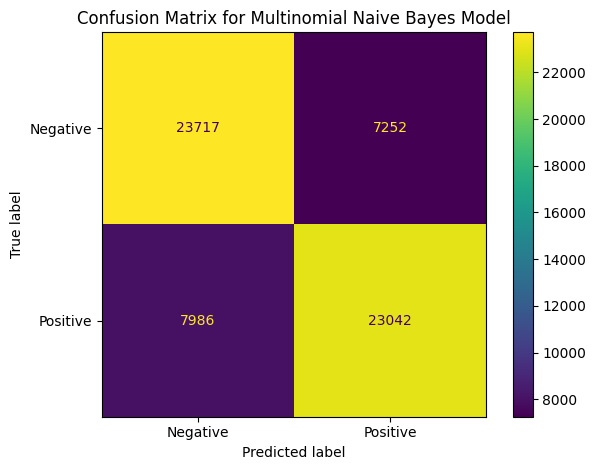

In [ ]:
# Calculate the confusion matrix for Multinomial Naive Bayes model
cm = confusion_matrix(y_test, nb.predict(X_test))
print('---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

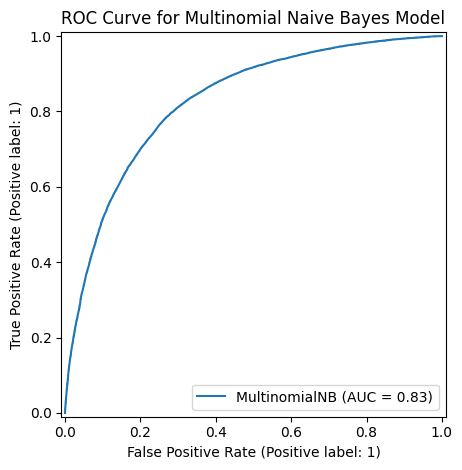

In [ ]:
# Plot the ROC curve for Multinomial Naive Bayes model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(nb, X_test, y_test)

plt.title('ROC Curve for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()

In [ ]:
# Classification report for Multinomial Naive Bayes model
print('---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------')
print(classification_report(y_test, nb.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------
              precision    recall  f1-score   support

    Negative       0.75      0.77      0.76     30969
    Positive       0.76      0.74      0.75     31028

    accuracy                           0.75     61997
   macro avg       0.75      0.75      0.75     61997
weighted avg       0.75      0.75      0.75     61997

------------------------------------------------------------


In [ ]:
# Initialize Support Vector Classifier model
svc = LinearSVC(max_iter=10000, random_state=42, C=1)

# Train and evaluate the model
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Display the evaluation metrics
svc_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Linear Support Vector Classifier Model')
print('--------------------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

Linear Support Vector Classifier Model
--------------------------------------
Accuracy: 0.7328419117054051
Precision: 0.7457103013399624
Recall: 0.7927678226118344
F1 Score: 0.7685193863842285
AUC-ROC: 0.7609581629769431


---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

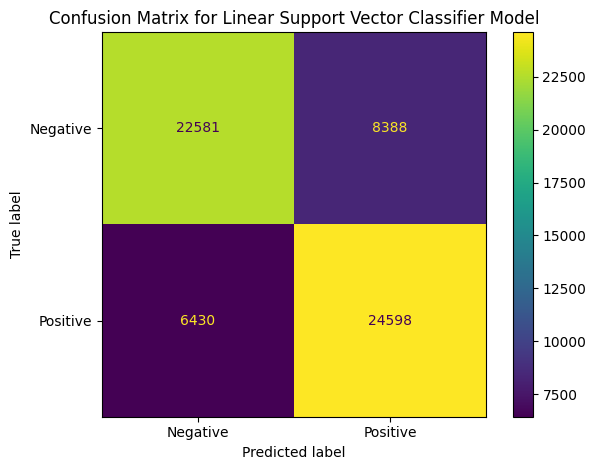

In [ ]:
# Calculate the confusion matrix for Linear Support Vector Classifier model
cm = confusion_matrix(y_test, svc.predict(X_test))
print('---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))

ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

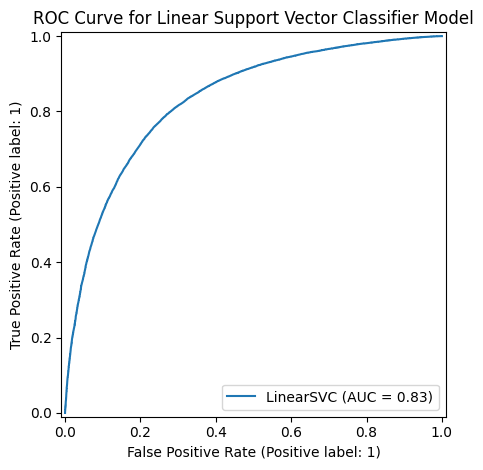

In [ ]:
# Plot the ROC curve for Linear Support Vector Classifier model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(svc, X_test, y_test)

plt.title('ROC Curve for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.show()

In [ ]:
# Classification report for Linear Support Vector Classifier model
print('---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------')
print(classification_report(y_test, svc.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------
              precision    recall  f1-score   support

    Negative       0.78      0.73      0.75     30969
    Positive       0.75      0.79      0.77     31028

    accuracy                           0.76     61997
   macro avg       0.76      0.76      0.76     61997
weighted avg       0.76      0.76      0.76     61997

------------------------------------------------------------


---------------------- Confusion Matrix for Multi-layer Perceptron Model ----------------------


<Figure size 800x600 with 0 Axes>

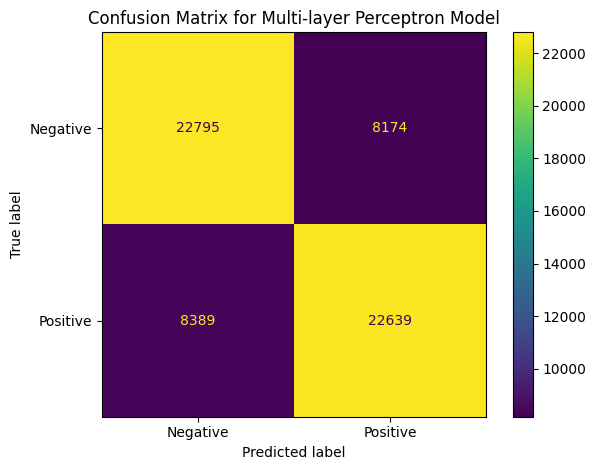

In [ ]:
# Calculate the confusion matrix for Multi-layer Perceptron model
cm = confusion_matrix(y_test, mlp.predict(X_test))
print('---------------------- Confusion Matrix for Multi-layer Perceptron Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multi-layer Perceptron Model')
plt.tight_layout()
plt.grid(False)
plt.show()

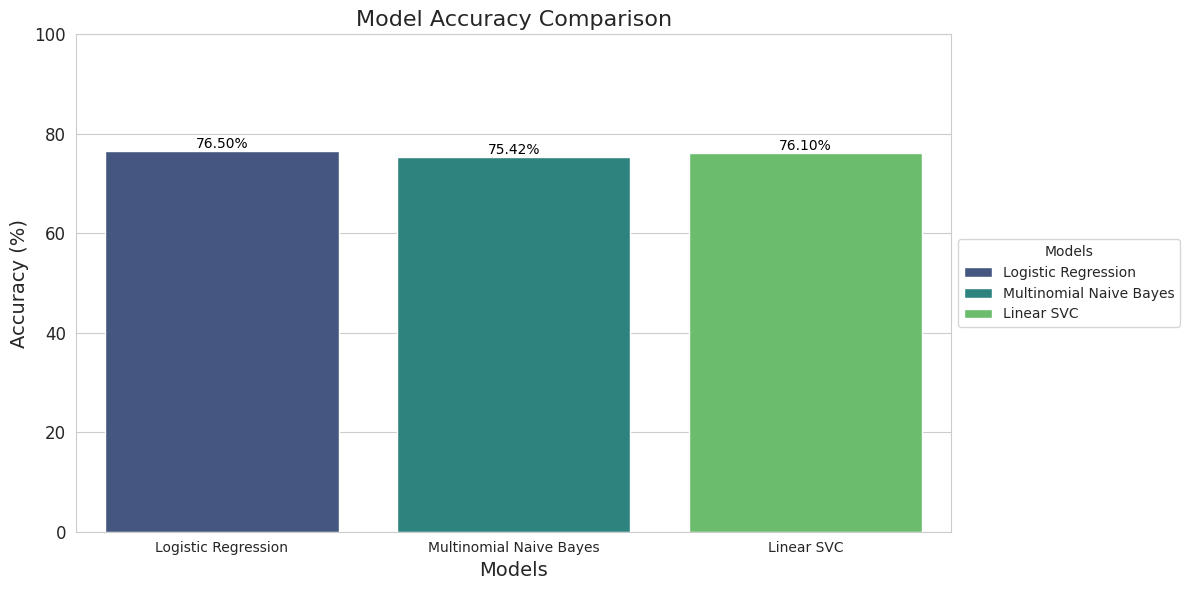

In [ ]:
model_accuracies = {
    'Logistic Regression': lr_accuracy,
    'Multinomial Naive Bayes': mnb_accuracy,
    'Linear SVC': svc_accuracy
}

accuracy_df = pd.DataFrame({'Model': list(model_accuracies.keys()),
                            'Accuracy': list(model_accuracies.values())})

accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df, palette='viridis')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(ha='center', fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2.,
                                           p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

handles = ax.patches
labels = accuracy_df['Model'].tolist()

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()